### PNEUMONIA
Pneumonia is characterized by an inflammation of the lung; specifically the inflammation of alveoli in the lungs, and can be accompanied by a build up of fluid or pus in the alveoli. Pneumonia can be caused by bacterial, viral, or fungal infections. In Malaysia, risk factors for pneumonia increase with age, and differ by gender and race (Department of Statistics Malaysia, 2024).    

Malaysia recorded pneumonia as the principal cause of death in 2023. A total of 18,181 (15.2%) medically certified deaths were attributed to pneumonia, exceeding deaths caused by heart disease for the first time in two decades (Department of Statistics Malaysia, 2024). There is now a growing need for the healthcare system to provide early interventions for pneumonia, and it all starts with a diagnosis.

![Pneumonia](https://my.clevelandclinic.org/-/scassets/images/org/health/articles/4471-pneumonia-01)

### MACHINE LEARNING FOR PNEUMONIA DETECTION
To provide a more conclusive diagnosis, a chest X-ray is often recommended as they are cheap and accessible (Usman et al., 2025). However, with the influx of pneumonia cases in Malaysia, there are bound to be delays and errors in chest X-ray assessments. Here is where machine learning models could be implemented to improve speed and aid the decision making process for doctors. In fact, some 22 government clinics have implemented AI screening technology to help detect lung cancer from chest X-rays (Hamsuddin, 2025). Hence, we can see that machine learning can be implemented in detecting and classifying pneumonia, and there is a vested interest to study how to build machine learning models and pipelines that would be best suited for the task.    

![News article](https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcQFpBWAkgJHaltPqPh70oNxWus9oPqFN8J7Ag&s)

### CONTENT
1. Data Preprocessing
2. Data Augmentation
3. Boosting
4. Training
5. Evaluation
6. Future Work

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [24]:
# the dataset was downloaded via kaggle's cli
# !/bin/bash
# kaggle datasets download paultimothymooney/chest-xray-pneumonia

import numpy as np
import pandas as pd

# files are placed in
# ./chest_xray

# import os
# for dirname, _, filenames in os.walk('.\chest_xray'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# prints all the files available

### Libraries

In [35]:
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
import keras
import cv2
from PIL import Image
from keras.models import Sequential
from keras.layers import Dense, Conv2D , MaxPool2D , Flatten , Dropout , Input, MaxPooling2D
from keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score
from sklearn.utils.class_weight import compute_class_weight

### Getting and Processing Images

In [26]:
import os
import kagglehub

base_dataset_path = kagglehub.dataset_download("paultimothymooney/chest-xray-pneumonia")
train_dir = os.path.join(base_dataset_path, 'chest_xray', 'train')
test_dir = os.path.join(base_dataset_path, 'chest_xray', 'test')
val_dir = os.path.join(base_dataset_path, 'chest_xray', 'val')

print(f"train_dir is set to: {train_dir}")
print(f"test_dir is set to: {test_dir}")
print(f"val_dir is set to: {val_dir}")

train_dir is set to: C:\Users\katev\.cache\kagglehub\datasets\paultimothymooney\chest-xray-pneumonia\versions\2\chest_xray\train
test_dir is set to: C:\Users\katev\.cache\kagglehub\datasets\paultimothymooney\chest-xray-pneumonia\versions\2\chest_xray\test
val_dir is set to: C:\Users\katev\.cache\kagglehub\datasets\paultimothymooney\chest-xray-pneumonia\versions\2\chest_xray\val


In [27]:
import os
project_path = '/content/drive/MyDrive/PROJECT/' # Updated path

if os.path.exists(project_path):
    print(f'Contents of {project_path}:')
    print(os.listdir(project_path))
else:
    print(f'The path {project_path} does not exist in your Google Drive.')
    print('Please ensure your Google Drive is mounted correctly and the `PROJECT/` structure exists.')

The path /content/drive/MyDrive/PROJECT/ does not exist in your Google Drive.
Please ensure your Google Drive is mounted correctly and the `PROJECT/` structure exists.


In [28]:
def check_images(folder):
    for root, _, files in os.walk(folder):
        for fname in files:
            path = os.path.join(root, fname)
            try:
                img = Image.open(path)
                img.verify() # Verify image integrity
                # No need to save or resize here, ImageDataGenerator handles it
            except FileNotFoundError:
                print("file not found")
            except PermissionError:
                print("no permission")
            except IOError as e:
                print(f"io error: {e}")
            except Exception as e:
                print(f"unexpected error: {e}")

check_images(train_dir)
check_images(test_dir)
check_images(val_dir)

In [29]:
def get_valid_images(folder):

    image_paths = []
    labels = []

    for class_name in os.listdir(folder):
        class_dir = os.path.join(folder, class_name)
        if not os.path.isdir(class_dir):
            continue

        for fname in os.listdir(class_dir):
            if fname.startswith('.') or fname.endswith('.DS_Store'):
                continue

            path = os.path.join(class_dir, fname)
            try:
                Image.open(path).verify()
                image_paths.append(path)
                labels.append(class_name)
            except Exception:
                print(f"Skipping invalid image: {path}")

    df = pd.DataFrame({'filename': image_paths, 'class_name': labels})
    return df

train_df = get_valid_images(train_dir)
val_df   = get_valid_images(val_dir)
test_df  = get_valid_images(test_dir)

### EDA

In [ ]:
print(train_df['class_name'].value_counts())

class_name
PNEUMONIA    3875
NORMAL       1341
Name: count, dtype: int64


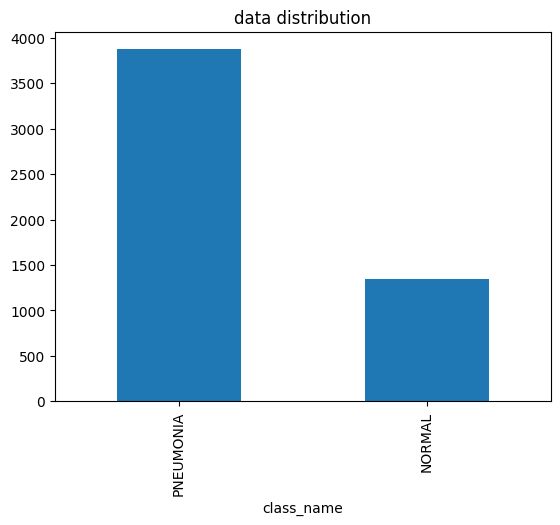

In [ ]:
train_df['class_name'].value_counts().plot(kind='bar',title='data distribution')
plt.show()

In [ ]:
pneumonia_samples = (train_df[train_df['class_name']=='NORMAL']['filename'].iloc[:5]).tolist()
normal_samples = (train_df[train_df['class_name']=='PNEUMONIA']['filename'].iloc[:5]).tolist()

In [ ]:
samples = pneumonia_samples + normal_samples

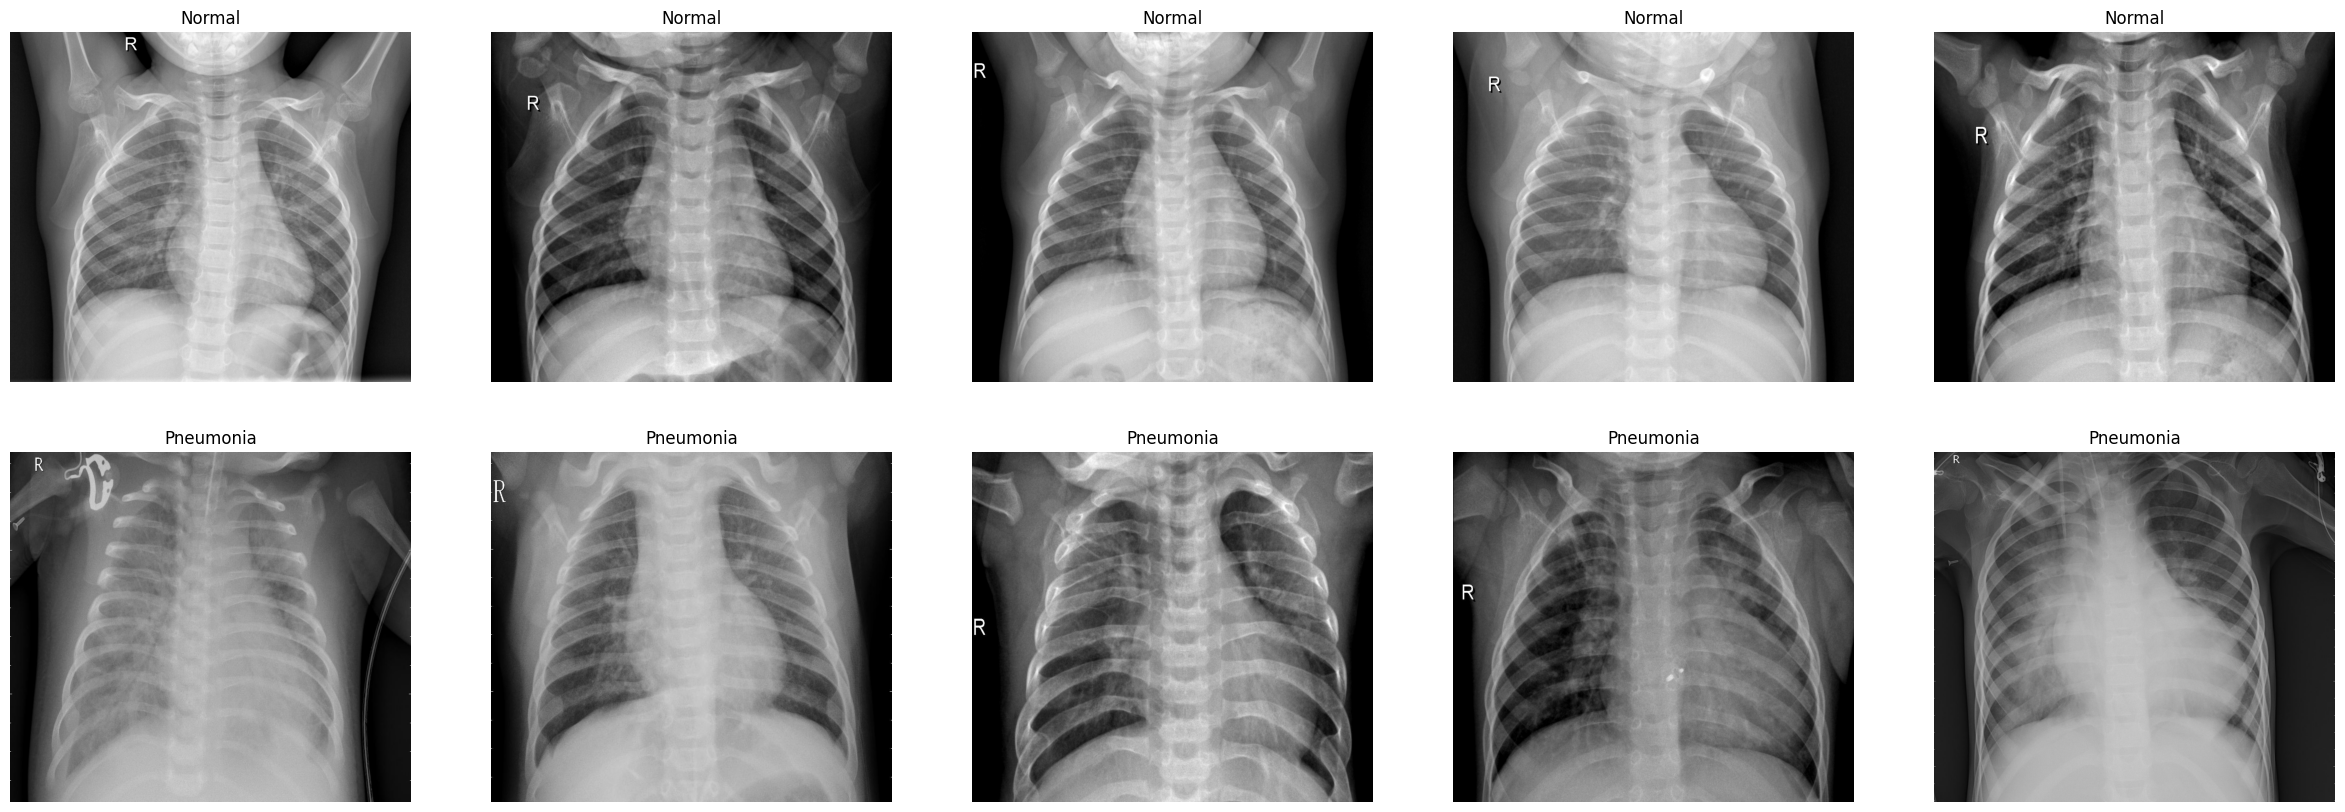

In [ ]:
f, ax = plt.subplots(2, 5, figsize=(30,10))
for i in range(10):
    img = cv2.imread(samples[i])
    ax[i//5, i%5].imshow(img, cmap='gray')
    if i<5:
        ax[i//5, i%5].set_title('Normal')
    else:
        ax[i//5, i%5].set_title('Pneumonia')
    ax[i//5, i%5].axis('off')
    ax[i//5, i%5].set_aspect('auto')
plt.show()

From the image samples above, we can see that aside from some instances, it is quite hard to differentiate between X-rays with pneumonia and normal X-rays. Furthermore, X-rays taken have varying levels of brightness, due to data being sourced from different hospitals. We can check pixel intensity and frequency, and if it seems inconsistent, can be normalized later.

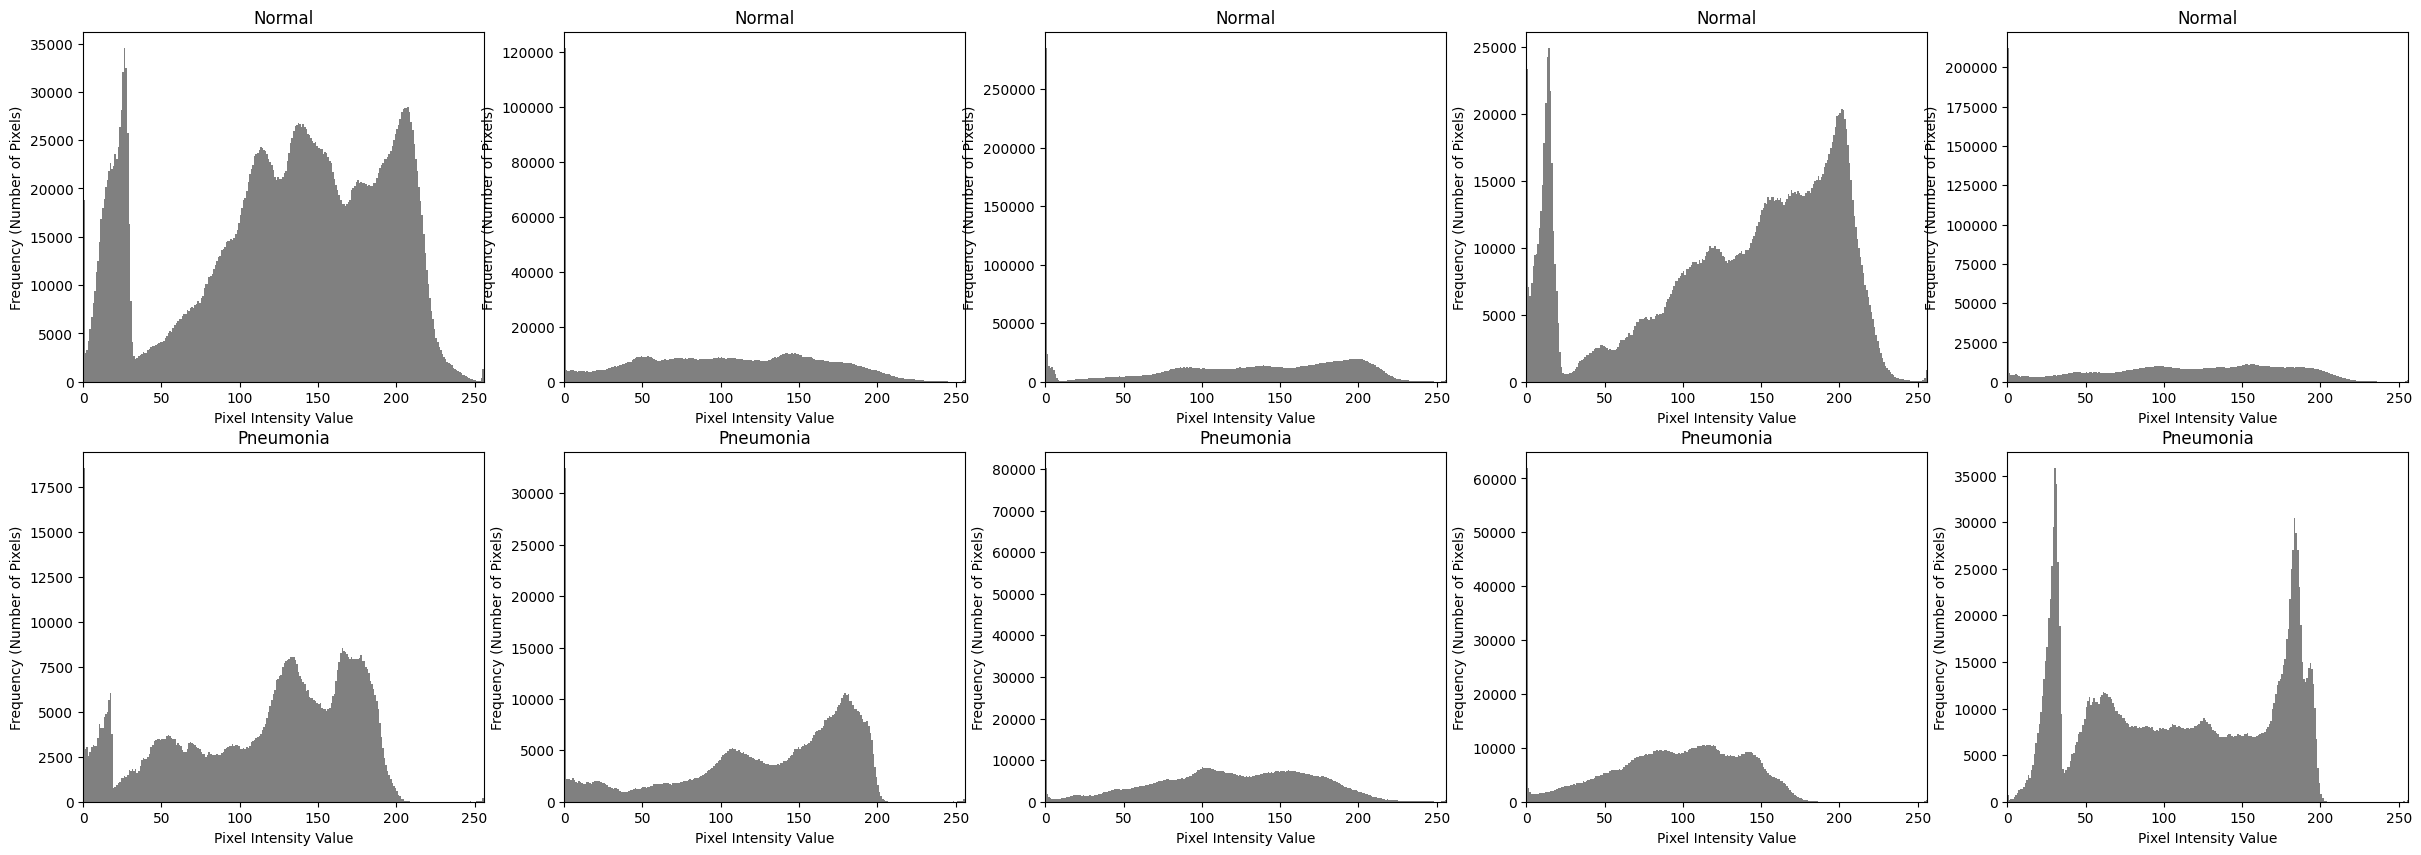

In [ ]:
f, axes = plt.subplots(2, 5, figsize=(30,10))
for i in range(10):
    img = cv2.imread(samples[i], cv2.IMREAD_GRAYSCALE)
    ax_flat = axes.flatten()
    ax = ax_flat[i]
    if i<5:
        ax.hist(img.ravel(),256,range=[0,256],color='gray')
        ax.set_xlabel('Pixel Intensity Value')
        ax.set_ylabel('Frequency (Number of Pixels)')
        ax.set_xlim([0, 256])
        ax.set_title('Normal')
    else:
        ax.hist(img.ravel(),256,range=[0,256],color='gray')
        ax.set_xlabel('Pixel Intensity Value')
        ax.set_ylabel('Frequency (Number of Pixels)')
        ax.set_xlim([0, 256])
        ax.set_title('Pneumonia')
plt.show()

From the pixel intensities, it shows that patients with pneumonia tend to have higher frequency of pixels at the 150-225 range. Normal X-rays tend to have a wider spread than the normal X-rays.

In [ ]:
train_df.head()

filename class_name
0  C:\Users\katev\.cache\kagglehub\datasets\pault...     NORMAL
1  C:\Users\katev\.cache\kagglehub\datasets\pault...     NORMAL
2  C:\Users\katev\.cache\kagglehub\datasets\pault...     NORMAL
3  C:\Users\katev\.cache\kagglehub\datasets\pault...     NORMAL
4  C:\Users\katev\.cache\kagglehub\datasets\pault...     NORMAL

In [ ]:
def get_image_dimensions(path):
    with Image.open(path) as img:
        width, height = img.size
        return width, height

dimensions = train_df['filename'].apply(get_image_dimensions)
dimensions_df = pd.DataFrame()
dimensions_df[['Width','Height']] = pd.DataFrame(dimensions.tolist())

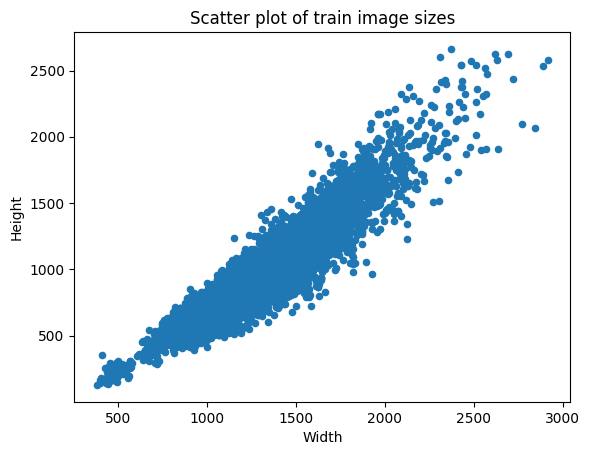

In [ ]:
dimensions_df.plot.scatter(x='Width', y='Height')
plt.title('Scatter plot of train image sizes')
plt.xlabel('Width')
plt.ylabel('Height')
plt.show()

In [ ]:
dimensions_df.describe()

Width       Height
count  5216.000000  5216.000000
mean   1320.610813   968.074770
std     355.298743   378.855691
min     384.000000   127.000000
25%    1056.000000   688.000000
50%    1284.000000   888.000000
75%    1552.000000  1187.750000
max    2916.000000  2663.000000

The dataset images come in many diferent dimensions, with minimum width being 384, and minimum height being 127. Hence, images should be resized later during preprocessing before being fed into our model.

### DATA AUGMENTATION AND RESIZING

In [30]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

val_datagen=ImageDataGenerator(rescale=1./255)
test_datagen=ImageDataGenerator(rescale=1./255)

In [31]:
train_generator = train_datagen.flow_from_dataframe(
    train_df,
    x_col='filename',
    y_col='class_name',
    target_size=(128, 128), # Reduced image size
    color_mode='grayscale',
    class_mode='categorical',
    batch_size=32,
    shuffle=True
)

val_generator = val_datagen.flow_from_dataframe(
    val_df,
    x_col='filename',
    y_col='class_name',
    target_size=(128, 128), # Reduced image size
    color_mode='grayscale',
    class_mode='categorical',
    batch_size=32,
    shuffle=False
)

test_generator = test_datagen.flow_from_dataframe(
    test_df,
    x_col='filename',
    y_col='class_name',
    target_size=(128, 128), # Reduced image size
    color_mode='grayscale',
    class_mode='categorical',
    batch_size=32,
    shuffle=False
)

Found 5216 validated image filenames belonging to 2 classes.
Found 16 validated image filenames belonging to 2 classes.
Found 624 validated image filenames belonging to 2 classes.


### BUILDING, TRAINING, AND EVALUATING THE MODEL

In [32]:
model = Sequential([
    Input(shape=(128, 128, 1)), # Updated input shape
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2,2)),

    Conv2D(128, (3,3), activation='relu'),
    MaxPooling2D((2,2)),

    Conv2D(256, (3,3), activation='relu'),
    MaxPooling2D((2,2)),

    # Conv2D(512, (3,3), activation='relu'),
    # MaxPooling2D((2,2)),

    Flatten(),
    Dense(512, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001)),
    Dropout(0.5),
    Dense(2, activation='softmax')
])

In [33]:
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━┓
┃ Layer (type)                   ┃ Output Shape           ┃      Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)              │ (None, 126, 126, 64)   │          640 │
├────────────────────────────────┼────────────────────────┼──────────────┤
│ max_pooling2d_3 (MaxPooling2D) │ (None, 63, 63, 64)     │            0 │
├────────────────────────────────┼────────────────────────┼──────────────┤
│ conv2d_4 (Conv2D)              │ (None, 61, 61, 128)    │       73,856 │
├────────────────────────────────┼────────────────────────┼──────────────┤
│ max_pooling2d_4 (MaxPooling2D) │ (None, 30, 30, 128)    │            0 │
├────────────────────────────────┼────────────────────────┼──────────────┤
│ conv2d_5 (Conv2D)              │ (None, 28, 28, 256)    │      295,168 │
├────────────────────────────────┼────────────────────────┼──────────────┤
│ max_pooling2d_5 (MaxPooling2D) │ (None, 14, 14, 256)    │            0 │
├────────────────────────────────┼────────────────────────┼──────────────┤
│ flatten_1 (Flatten)            │ (None, 50176)          │            0 │
├────────────────────────────────┼────────────────────────┼──────────────┤
│ dense_2 (Dense)                │ (None, 512)            │   25,690,624 │
├────────────────────────────────┼────────────────────────┼──────────────┤
│ dropout_1 (Dropout)            │ (None, 512)            │            0 │
├────────────────────────────────┼────────────────────────┼──────────────┤
│ dense_3 (Dense)                │ (None, 2)              │        1,026 │
└────────────────────────────────┴────────────────────────┴──────────────┘

 Total params: 26,061,314 (99.42 MB)

 Trainable params: 26,061,314 (99.42 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
callbacks = [
    EarlyStopping(patience=3  , restore_best_weights=True),
    ModelCheckpoint('best_pneumonia_classifier.keras', save_best_only=True)
]

history = model.fit(
    train_generator,
    epochs=20,
    validation_data=val_generator,
    callbacks=callbacks
)

Epoch 1/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 346s 2s/step - accuracy: 0.7546 - loss: 0.6511 - val_accuracy: 0.8750 - val_loss: 0.6024
Epoch 2/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 300s 2s/step - accuracy: 0.8436 - loss: 0.4163 - val_accuracy: 0.7500 - val_loss: 0.6151
Epoch 3/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 244s 1s/step - accuracy: 0.8719 - loss: 0.3631 - val_accuracy: 0.9375 - val_loss: 0.4046
Epoch 4/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 260s 1s/step - accuracy: 0.8882 - loss: 0.3299 - val_accuracy: 0.6875 - val_loss: 0.6287
Epoch 5/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 269s 2s/step - accuracy: 0.9020 - loss: 0.2991 - val_accuracy: 0.7500 - val_loss: 0.5415
Epoch 6/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 457s 3s/step - accuracy: 0.8961 - loss: 0.3050 - val_accuracy: 0.7500 - val_loss: 0.5453


In [ ]:
y_true = test_generator.classes
y_prob = model.predict(test_generator)
y_pred = np.argmax(y_prob, axis=1)

20/20 ━━━━━━━━━━━━━━━━━━━━ 27s 1s/step


In [ ]:
cm = confusion_matrix(y_true, y_pred)
print(cm)
# tn fp
# fn tp

[[196  38]
 [ 35 355]]


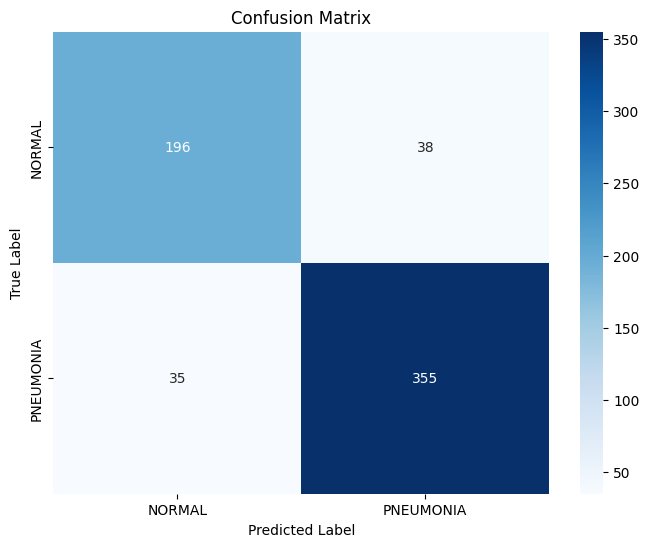

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

cm_values = cm

class_names = ['NORMAL', 'PNEUMONIA']

plt.figure(figsize=(8, 6))
sns.heatmap(cm_values, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

TP: pneumonia correctly detected    
FN: pneumonia missed (critical error)    
FP: normal misclassified as pneumonia    
TN: normal correctly classified

In [ ]:
test_generator.class_indices

{'NORMAL': 0, 'PNEUMONIA': 1}

In [ ]:
precision = precision_score(y_true, y_pred, pos_label=1)
recall = recall_score(y_true, y_pred, pos_label=1)
f1 = f1_score(y_true, y_pred, pos_label=1)

print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1-score: {f1}")

Precision: 0.9033078880407125
Recall: 0.9102564102564102
F1-score: 0.9067688378033205


Precision = TP/(TP+FP)    
-> when the model says pneumonia, how often is it actually pneumonia? (not many normal case flagged as pneumonia)    
Recall = TP/(TP+FN)    
-> out of all real pneumonia, how many did the model detect? (if high, means little pneumonia cases missed)    
F1-score: 2*(precision*recall)/(precision+recall)    
-> is the model doing well overall on pneumonia detection
    

Overall, the scores above shows that the model has a high recall (0.94) which means it detects 94% of pneumonia casses correctly and misses 6% of them. The model has a precision of 81%, which means it might predict pneumonia when it isn't there, leading to higher workload for doctors. At this stage, this model would be useful for triage, but inreasing precision could make it work as a standalone diagnostic tool, which might save a hospital's time and resources.

In [ ]:
test_loss, test_acc = model.evaluate(test_generator)
print(f"test accuracy: {test_acc*100:.2f}%")

20/20 ━━━━━━━━━━━━━━━━━━━━ 21s 963ms/step - accuracy: 0.8830 - loss: 0.3751
test accuracy: 88.30%


# analyze misclassifications

In [ ]:
y_true_np = np.array(y_true)
misclassified_indices = np.where(y_true_np != y_pred)[0]

misclassified_filenames = test_df.iloc[misclassified_indices]['filename'].values
misclassified_true_labels_numeric = y_true_np[misclassified_indices]
misclassified_predicted_labels_numeric = y_pred[misclassified_indices]

# Create a mapping from numeric label to class name
label_map = {v: k for k, v in test_generator.class_indices.items()}

misclassified_true_labels_str = [label_map[label] for label in misclassified_true_labels_numeric]
misclassified_predicted_labels_str = [label_map[label] for label in misclassified_predicted_labels_numeric]

misclassified_df = pd.DataFrame({
    'filename': misclassified_filenames,
    'true_label': misclassified_true_labels_str,
    'predicted_label': misclassified_predicted_labels_str
})

print("Number of misclassified images:", len(misclassified_df))
print("First 5 misclassified images:")
print(misclassified_df.head())

Number of misclassified images: 73
First 5 misclassified images:
                                            filename true_label  \
0  C:\Users\katev\.cache\kagglehub\datasets\pault...     NORMAL   
1  C:\Users\katev\.cache\kagglehub\datasets\pault...     NORMAL   
2  C:\Users\katev\.cache\kagglehub\datasets\pault...     NORMAL   
3  C:\Users\katev\.cache\kagglehub\datasets\pault...     NORMAL   
4  C:\Users\katev\.cache\kagglehub\datasets\pault...     NORMAL   

  predicted_label  
0       PNEUMONIA  
1       PNEUMONIA  
2       PNEUMONIA  
3       PNEUMONIA  
4       PNEUMONIA  



Number of False Positives (Normal predicted as Pneumonia): 38
Number of False Negatives (Pneumonia predicted as Normal): 35


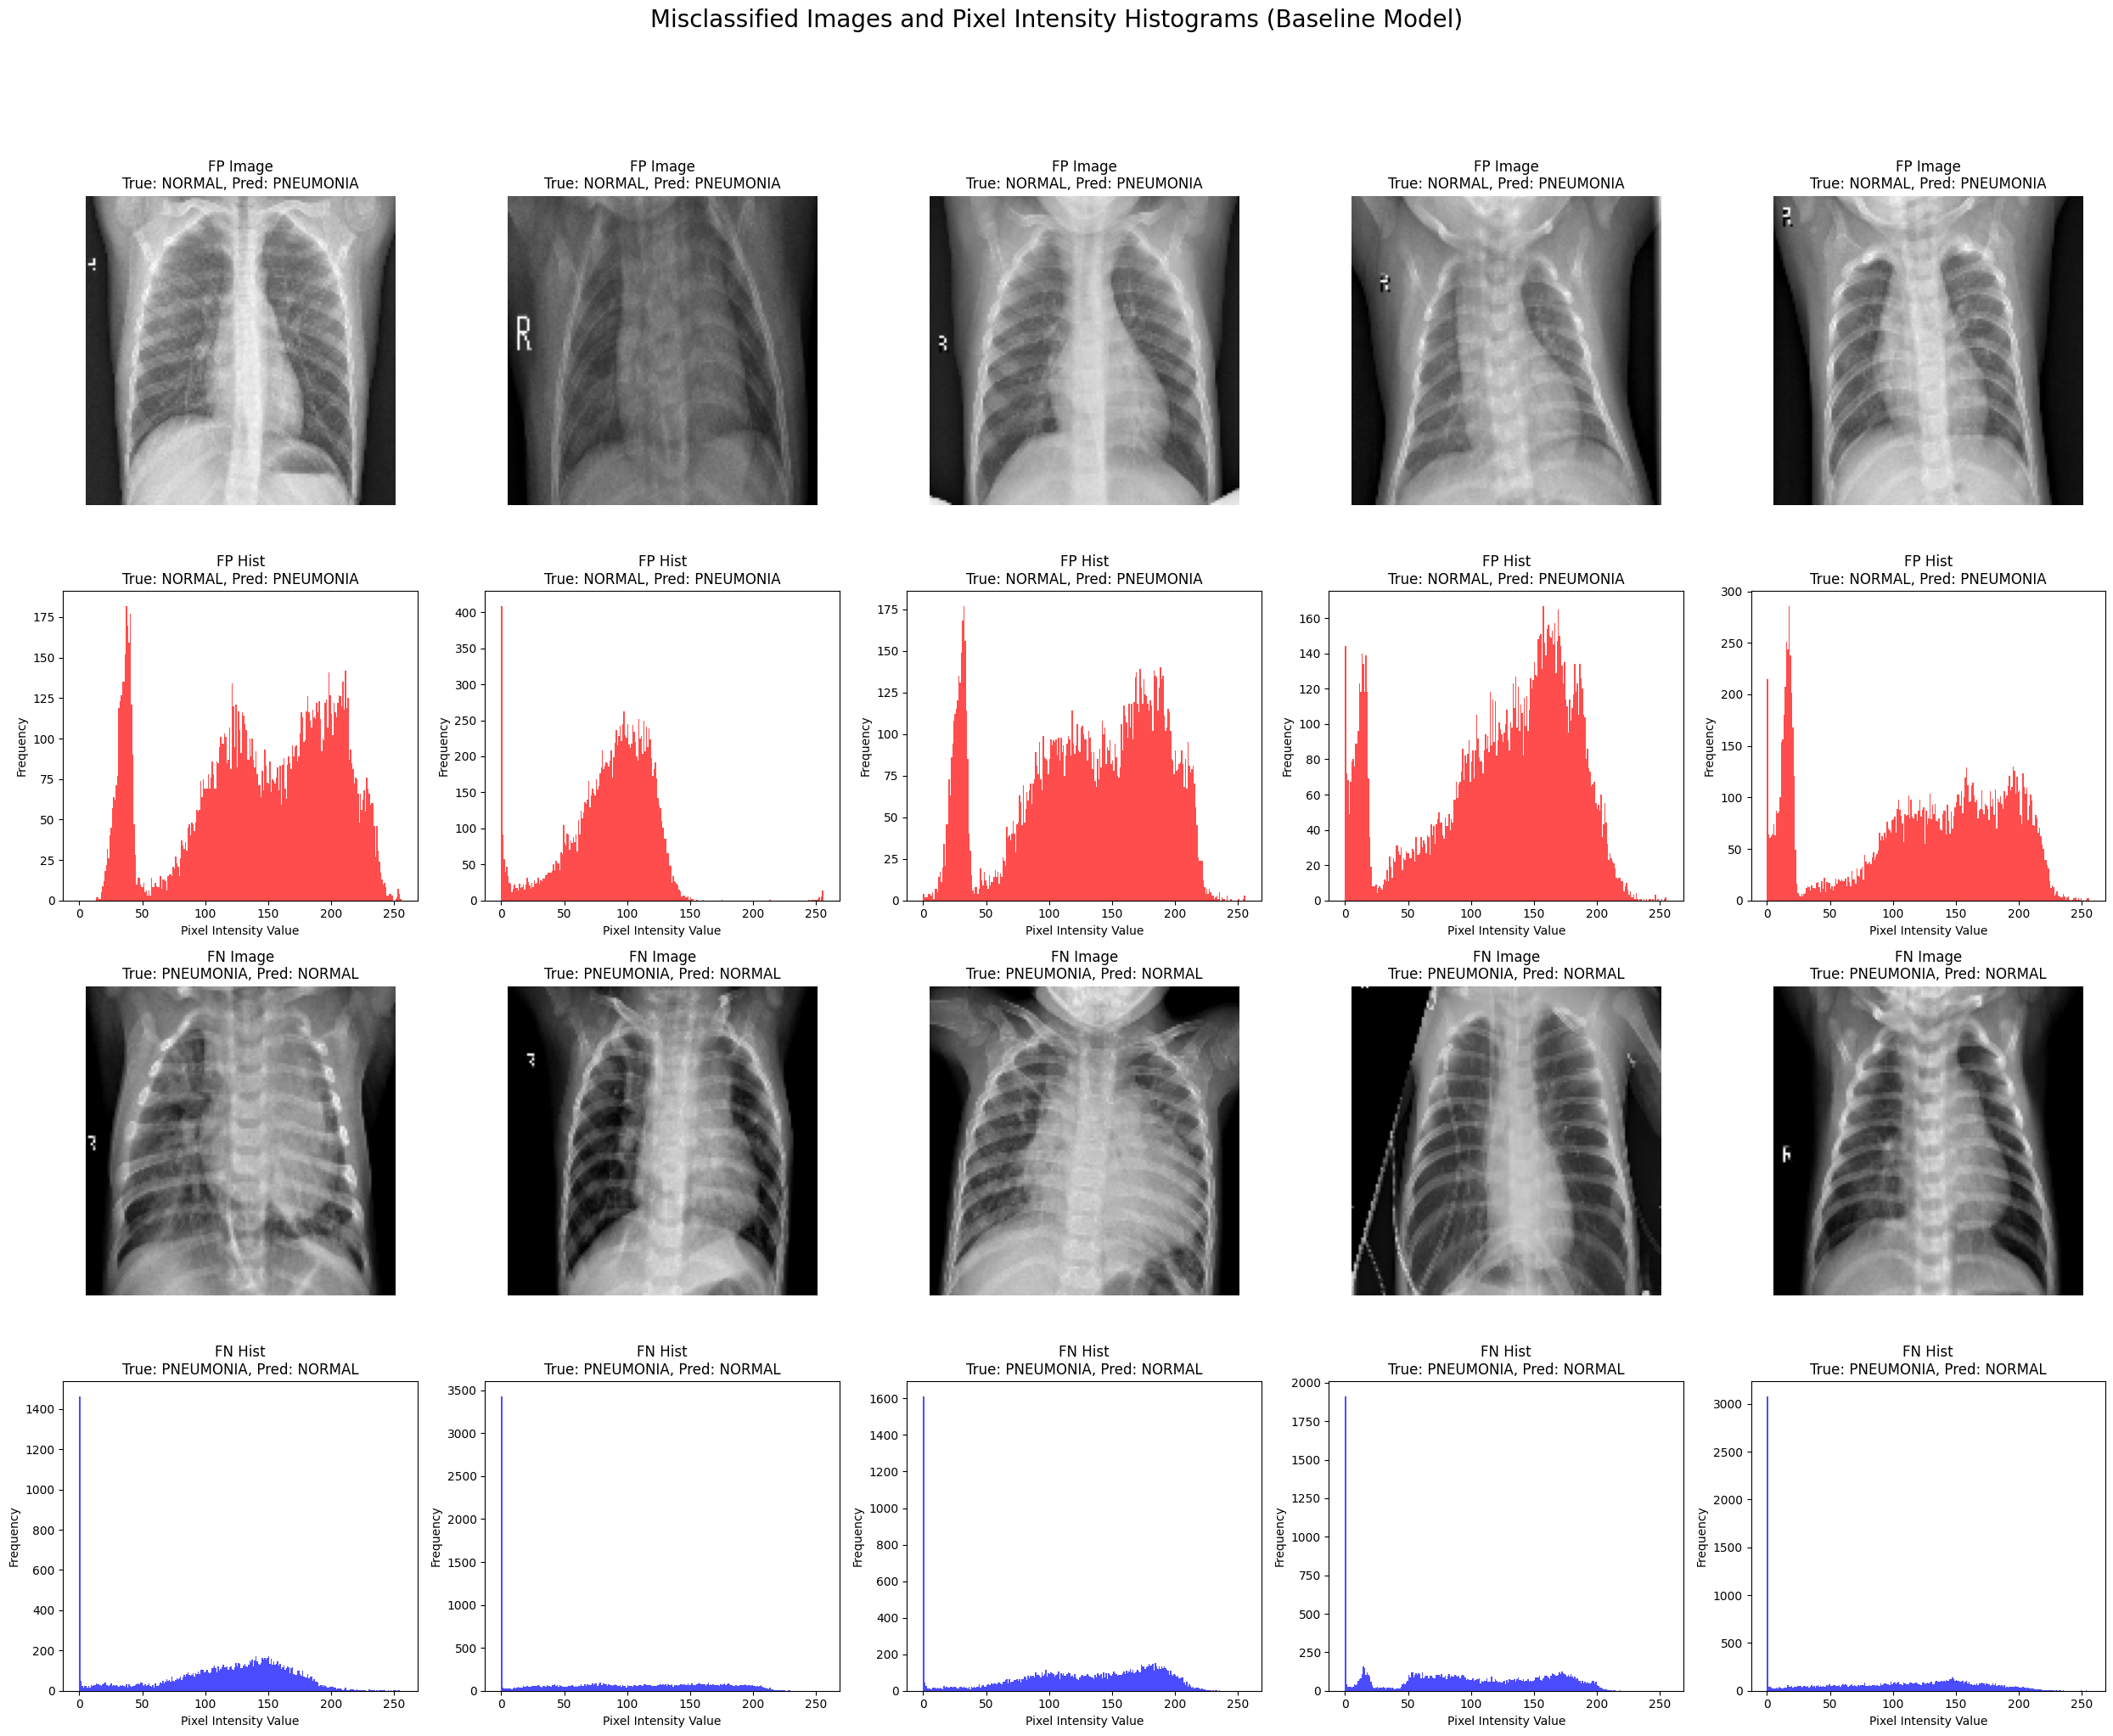

In [ ]:
false_positives_df = misclassified_df[
    (misclassified_df['true_label'] == 'NORMAL') &
    (misclassified_df['predicted_label'] == 'PNEUMONIA')
]

false_negatives_df = misclassified_df[
    (misclassified_df['true_label'] == 'PNEUMONIA') &
    (misclassified_df['predicted_label'] == 'NORMAL')
]

print(f"\nNumber of False Positives (Normal predicted as Pneumonia): {len(false_positives_df)}")
print(f"Number of False Negatives (Pneumonia predicted as Normal): {len(false_negatives_df)}")

num_samples_to_plot = 5
fp_samples = false_positives_df.head(num_samples_to_plot)
fn_samples = false_negatives_df.head(num_samples_to_plot)

fig, axes = plt.subplots(4, 5, figsize=(25, 20))
fig.suptitle('Misclassified Images and Pixel Intensity Histograms (Baseline Model)', fontsize=20, y=1.02)

# Row 1: False Positive Images (Normal -> Pneumonia)
for i, (idx, row) in enumerate(fp_samples.iterrows()):
    img = cv2.imread(row['filename'])
    if img is not None:
        img = cv2.resize(img, (128, 128)) # Resize image to 128x128
        axes[0, i].imshow(img, cmap='gray')
        axes[0, i].set_title(f"FP Image\nTrue: {row['true_label']}, Pred: {row['predicted_label']}")
    else:
        axes[0, i].set_title(f"FP Image\nCould not load {os.path.basename(row['filename'])}")
    axes[0, i].axis('off')

# Row 2: False Positive Histograms
for i, (idx, row) in enumerate(fp_samples.iterrows()):
    img_gray = cv2.imread(row['filename'], cv2.IMREAD_GRAYSCALE)
    if img_gray is not None:
        img_gray = cv2.resize(img_gray, (128, 128)) # Resize for histogram as well for consistency
        axes[1, i].hist(img_gray.ravel(), bins=256, range=(0, 256), color='red', alpha=0.7)
        axes[1, i].set_title(f"FP Hist\nTrue: {row['true_label']}, Pred: {row['predicted_label']}")
        axes[1, i].set_xlabel('Pixel Intensity Value')
        axes[1, i].set_ylabel('Frequency')
    else:
        axes[1, i].set_title(f"FP Hist\nCould not load {os.path.basename(row['filename'])}")

# Row 3: False Negative Images (Pneumonia -> Normal)
for i, (idx, row) in enumerate(fn_samples.iterrows()):
    img = cv2.imread(row['filename'])
    if img is not None:
        img = cv2.resize(img, (128, 128)) # Resize image to 128x128
        axes[2, i].imshow(img, cmap='gray')
        axes[2, i].set_title(f"FN Image\nTrue: {row['true_label']}, Pred: {row['predicted_label']}")
    else:
        axes[2, i].set_title(f"FN Image\nCould not load {os.path.basename(row['filename'])}")
    axes[2, i].axis('off')

# Row 4: False Negative Histograms
for i, (idx, row) in enumerate(fn_samples.iterrows()):
    img_gray = cv2.imread(row['filename'], cv2.IMREAD_GRAYSCALE)
    if img_gray is not None:
        img_gray = cv2.resize(img_gray, (128, 128)) # Resize for histogram as well for consistency
        axes[3, i].hist(img_gray.ravel(), bins=256, range=(0, 256), color='blue', alpha=0.7)
        axes[3, i].set_title(f"FN Hist\nTrue: {row['true_label']}, Pred: {row['predicted_label']}")
        axes[3, i].set_xlabel('Pixel Intensity Value')
        axes[3, i].set_ylabel('Frequency')
    else:
        axes[3, i].set_title(f"FN Hist\nCould not load {os.path.basename(row['filename'])}")

plt.tight_layout(rect=[0, 0, 1, 0.96]) # Adjust rect to prevent title overlap
plt.show()

### BASE MODEL REVIEW

Regular CNN model with data aug returned a test accuracy of 83, precision of 81 and recall of 94. This is the baseline. Now, we can improve the model's precision in order to reduce false positives and increase its diagnostic ability, instead of treating it as a screening tool.

### THRESHOLD TUNING (NOT INCLUDED IN FINAL PROJECT)
Threshold tuning is the process of adjusting the probability cutoff (p) used to decide class predictions in a classifier. Our model is a categorical classifier with softmax output, where number of categories, n = 2. By default, the probability threshold for the positive class is 0.5, meaning if p > 0.5 for a class, it will be the positive class.     

Adjusting the threshold will change the balance between precision and recall. A higher threshold generally reduces false positives and increases precision, which is our desired metric. By increasing the threshold, the model can make its pneumonia predictions more confident, reducing misclassified normal cases.    

In the next section, we try to find the best threshold value that will increase precision without substantially harming recall, to create a model that is suitable for diagnosis.

![Threshold tuning](https://towardsdatascience.com/wp-content/uploads/2021/01/1Q_Nu_Mm2FbD9QTClkgMLRg.png)

The graph above shows the relationship between the scores of different metrics (precision, recall, f1) to the threshold, which allows us to pick the best threshold for a model.

In [ ]:
y_prob = model.predict(test_generator)
y_true = test_generator.classes

20/20 ━━━━━━━━━━━━━━━━━━━━ 13s 628ms/step


In [ ]:
pneumonia_prob = y_prob[:,1]
precisions, recalls, f1s = [], [], []
thresholds = [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1]
for t in thresholds:
  y_pred = (pneumonia_prob > t).astype(int)
  precisions.append(precision_score(y_true, y_pred))
  recalls.append(recall_score(y_true, y_pred))
  f1s.append(f1_score(y_true, y_pred))

C:\Users\katev\my_python_space\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


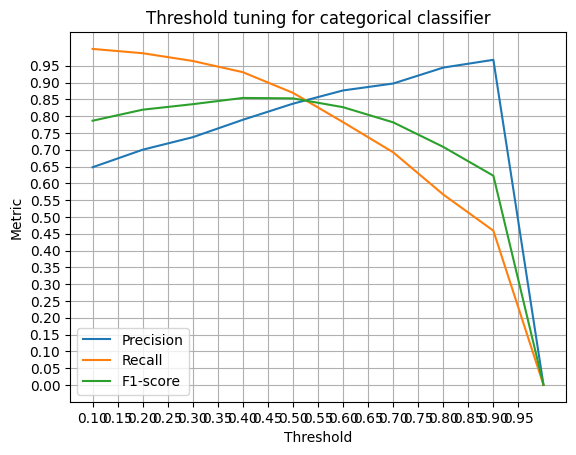

In [ ]:
plt.plot(thresholds, precisions, label='Precision')
plt.plot(thresholds, recalls, label='Recall')
plt.plot(thresholds, f1s, label='F1-score')
plt.xticks(np.arange(0.1, 1, 0.05))
plt.yticks(np.arange(0, 1, 0.05))
plt.xlabel('Threshold')
plt.ylabel('Metric')
plt.title('Threshold tuning for categorical classifier')
plt.legend()
plt.grid(True)
plt.show()

From the graph above, at threshold \~0.425, we get the most balanced tradeoff between precision and F1, as they have the same value and converges. However, at this point, recall drops a little too low (\~88%), meaning the model isn't as good at finding pneumonia as previously (~94%). Given that this model is to be used in a clinical setting, it is crucial for recall to be higher. In this case, the threshold of 0.4 seems to offer a good tradeoff between precision and recall, by increasing precision to ~89% (roughly 8% increase) while recall drops to ~90% (roughly 4% decrease).

In [ ]:
y_prob = model.predict(test_generator)
pneumonia_prob = y_prob[:,1]
t_best = 0.4
y_pred = (pneumonia_prob > t_best).astype(int)

20/20 ━━━━━━━━━━━━━━━━━━━━ 6s 284ms/step


In [ ]:
precision = precision_score(y_true, y_pred, pos_label=1)
recall = recall_score(y_true, y_pred, pos_label=1)
f1 = f1_score(y_true, y_pred, pos_label=1)
cm = confusion_matrix(y_true, y_pred)

In [ ]:
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1-score: {f1}")
print(cm)

Precision: 0.8673218673218673
Recall: 0.9051282051282051
F1-score: 0.8858218318695107
[[180  54]
 [ 37 353]]


### CONCLUSION
This notebook was built by referencing those built by users Paul Mooney (https://www.kaggle.com/code/paultimothymooney/detecting-pneumonia-in-x-ray-images), Fathy Sahlool (https://www.kaggle.com/code/fathyfathysahlool/pneumonia-detection-chest-x-ray-cnn-acc-100) and Sanwal Yousaf (https://www.kaggle.com/code/sanwal092/intro-to-cnn-using-keras-to-predict-pneumonia) on Kaggle.

From Sahlool's and Yousaf's notebooks, we got the idea to increase training samples by using data augmentation. This is as far as our approach mirrors theirs, as our latter steps differ.

Mooney tackles with data imbalance by undersampling, which we did not do as the training set was already so small (5216 images). Instead, we opted to follow Yousaf's and Sahlool's approach of data augmentation in order to increase variety and training samples. We used more options (rotate, width_shift, height_shift) compared to them while augmenting, as we found it created better results for the model.

While building the model, we experimented with different sizes of images (128x128, 512x512, 1024x1024). The amount of time it took for the models to be trained increased as the image size increased, and we opted for 512x512 as the final size because:

1. most images in the dataset have either a width or height of 1000px
2. the smallest height and width in the image dataset is 127px and 384px respectively
3. exploding a small image to a big one (500 -> 1000) will make the edges blurry, while
4. reducing an image's size might make images lose fine-grained details

Hence, we opted for the 512x512 size.

We also experimented with different numbers of layers (3, 4, and 5) and while models with more layers did better, it did not do so by much and took much longer to run, which was not a beneficial tradeoff. So, we stuck with a 4 layer model. (3 layer -

finally, biggest deal is we modified threshold. seemed to be the simplest thing to get the biggest performance change with little tradeoff in terms of time.

in the end, our methods differed from those we referenced, but we scored better than mooney in terms of recall, precision, and f1.

# CLASS WEIGHTING

In [ ]:
classes = np.unique(train_df['class_name'])
class_weights = compute_class_weight(class_weight='balanced', classes=classes, y=train_df['class_name'])
class_weights_dict = dict(zip(np.unique(train_generator.classes), class_weights))

history = model.fit(
    train_generator,
    epochs=20,
    validation_data=val_generator,
    callbacks=callbacks,
    class_weight=class_weights_dict
)

In [ ]:
y_true = test_generator.classes
y_prob = model.predict(test_generator)
y_pred = np.argmax(y_prob, axis=1)

cm = confusion_matrix(y_true, y_pred)
print(cm)

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

cm_values = cm

class_names = ['NORMAL', 'PNEUMONIA']

plt.figure(figsize=(8, 6))
sns.heatmap(cm_values, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
precision = precision_score(y_true, y_pred, pos_label=1)
recall = recall_score(y_true, y_pred, pos_label=1)
f1 = f1_score(y_true, y_pred, pos_label=1)

print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1-score: {f1}")

In [ ]:
test_loss, test_acc = model.evaluate(test_generator)
print(f"test accuracy: {test_acc*100:.2f}%")

In [ ]:
label_map = {v: k for k, v in test_generator.class_indices.items()}

y_true_np = np.array(y_true)
misclassified_indices = np.where(y_true_np != y_pred)[0]

misclassified_filenames = test_df.iloc[misclassified_indices]['filename'].values
misclassified_true_labels_numeric = y_true_np[misclassified_indices]
misclassified_predicted_labels_numeric = y_pred[misclassified_indices]

misclassified_true_labels_str = [label_map[label] for label in misclassified_true_labels_numeric]
misclassified_predicted_labels_str = [label_map[label] for label in misclassified_predicted_labels_numeric]

misclassified_df = pd.DataFrame({
    'filename': misclassified_filenames,
    'true_label': misclassified_true_labels_str,
    'predicted_label': misclassified_predicted_labels_str
})

print("Number of misclassified images:", len(misclassified_df))
print("First 5 misclassified images:")
print(misclassified_df.head())


false_positives_df = misclassified_df[
    (misclassified_df['true_label'] == 'NORMAL') &
    (misclassified_df['predicted_label'] == 'PNEUMONIA')
]

false_negatives_df = misclassified_df[
    (misclassified_df['true_label'] == 'PNEUMONIA') &
    (misclassified_df['predicted_label'] == 'NORMAL')
]

print(f"\nNumber of False Positives (Normal predicted as Pneumonia): {len(false_positives_df)}")
print(f"Number of False Negatives (Pneumonia predicted as Normal): {len(false_negatives_df)}")

num_samples_to_plot = 5
fp_samples = false_positives_df.head(num_samples_to_plot)
fn_samples = false_negatives_df.head(num_samples_to_plot)

fig, axes = plt.subplots(4, 5, figsize=(25, 20))
fig.suptitle('Misclassified Images and Pixel Intensity Histograms (Baseline Model)', fontsize=20, y=1.02)

# Row 1: False Positive Images (Normal -> Pneumonia)
for i, (idx, row) in enumerate(fp_samples.iterrows()):
    img = cv2.imread(row['filename'])
    if img is not None:
        img = cv2.resize(img, (128, 128)) # Resize image to 128x128
        axes[0, i].imshow(img, cmap='gray')
        axes[0, i].set_title(f"FP Image\nTrue: {row['true_label']}, Pred: {row['predicted_label']}")
    else:
        axes[0, i].set_title(f"FP Image\nCould not load {os.path.basename(row['filename'])}")
    axes[0, i].axis('off')

# Row 2: False Positive Histograms
for i, (idx, row) in enumerate(fp_samples.iterrows()):
    img_gray = cv2.imread(row['filename'], cv2.IMREAD_GRAYSCALE)
    if img_gray is not None:
        img_gray = cv2.resize(img_gray, (128, 128)) # Resize for histogram as well for consistency
        axes[1, i].hist(img_gray.ravel(), bins=256, range=(0, 256), color='red', alpha=0.7)
        axes[1, i].set_title(f"FP Hist\nTrue: {row['true_label']}, Pred: {row['predicted_label']}")
    axes[1, i].set_xlabel('Pixel Intensity')
    axes[1, i].set_ylabel('Frequency')
    axes[1, i].set_xlim([0, 256])

# Row 3: False Negative Images (Pneumonia -> Normal)
for i, (idx, row) in enumerate(fn_samples.iterrows()):
    img = cv2.imread(row['filename'])
    if img is not None:
        img = cv2.resize(img, (128, 128))
        axes[2, i].imshow(img, cmap='gray')
        axes[2, i].set_title(f"FN Image\nTrue: {row['true_label']}, Pred: {row['predicted_label']}")
    else:
        axes[2, i].set_title(f"FN Image\nCould not load {os.path.basename(row['filename'])}")
    axes[2, i].axis('off')

# Row 4: False Negative Histograms
for i, (idx, row) in enumerate(fn_samples.iterrows()):
    img_gray = cv2.imread(row['filename'], cv2.IMREAD_GRAYSCALE)
    if img_gray is not None:
        img_gray = cv2.resize(img_gray, (128, 128))
        axes[3, i].hist(img_gray.ravel(), bins=256, range=(0, 256), color='blue', alpha=0.7)
        axes[3, i].set_title(f"FN Hist\nTrue: {row['true_label']}, Pred: {row['predicted_label']}")
    axes[3, i].set_xlabel('Pixel Intensity')
    axes[3, i].set_ylabel('Frequency')
    axes[3, i].set_xlim([0, 256])

plt.tight_layout(rect=[0, 0.03, 1, 0.98]) # Adjust layout to prevent suptitle overlap
plt.show()

# OVERSAMPLING
- implement random oversampling for the minority class ('NORMAL') in the training dataset (`train_df`) to address class imbalance
- separate the `train_df` into 'NORMAL' and 'PNEUMONIA' dataframes, duplicating the 'NORMAL' samples to balance the class counts, and then concatenating and shuffling these to form a new, balanced `train_df`
- recreate the `train_generator` using this new balanced dataframe

In [ ]:
normal_df = train_df[train_df['class_name'] == 'NORMAL']
pneumonia_df = train_df[train_df['class_name'] == 'PNEUMONIA']

print(f"normal_df shape: {normal_df.shape}")
print(f"pneumonia_df shape: {pneumonia_df.shape}")

normal_df shape: (1341, 2)
pneumonia_df shape: (3875, 2)


In [ ]:
num_pneumonia = len(pneumonia_df)
num_normal = len(normal_df)
samples_to_oversample = num_pneumonia - num_normal

oversampled_normal_df = normal_df.sample(n=samples_to_oversample, replace=True, random_state=42)

balanced_normal_df = pd.concat([normal_df, oversampled_normal_df])

print(f"Original normal_df shape: {normal_df.shape}")
print(f"Pneumonia_df shape: {pneumonia_df.shape}")
print(f"Samples to oversample: {samples_to_oversample}")
print(f"Oversampled normal_df shape (after concatenation): {balanced_normal_df.shape}")

Original normal_df shape: (1341, 2)
Pneumonia_df shape: (3875, 2)
Samples to oversample: 2534
Oversampled normal_df shape (after concatenation): (3875, 2)


In [ ]:
balanced_train_df = pd.concat([balanced_normal_df, pneumonia_df], axis=0)
balanced_train_df = balanced_train_df.sample(frac=1, random_state=42).reset_index(drop=True)

print(f"Shape of the new balanced training dataframe: {balanced_train_df.shape}")
print(f"Value counts of classes in balanced_train_df:\n{balanced_train_df['class_name'].value_counts()}")

Shape of the new balanced training dataframe: (7750, 2)
Value counts of classes in balanced_train_df:
class_name
NORMAL       3875
PNEUMONIA    3875
Name: count, dtype: int64


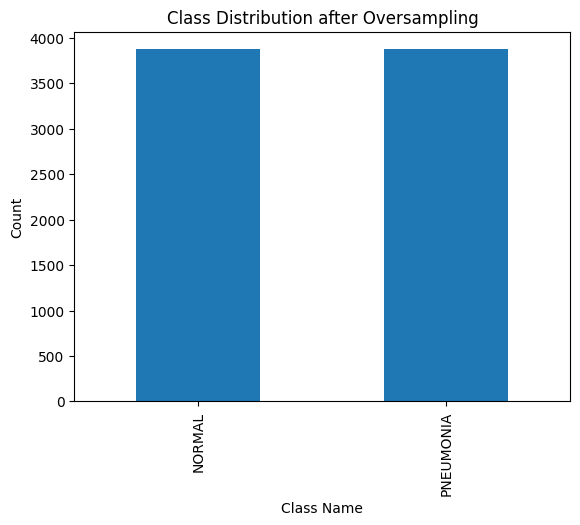

In [ ]:
balanced_train_df['class_name'].value_counts().plot(kind='bar', title='Class Distribution after Oversampling')
plt.xlabel('Class Name')
plt.ylabel('Count')
plt.show()

In [ ]:
train_generator = train_datagen.flow_from_dataframe(
    balanced_train_df,
    x_col='filename',
    y_col='class_name',
    target_size=(128, 128),
    color_mode='grayscale',
    class_mode='categorical',
    batch_size=32,
    shuffle=True
)

Found 7750 validated image filenames belonging to 2 classes.
Recreated train_generator with balanced_train_df.


In [ ]:
callbacks = [
    EarlyStopping(patience=3, restore_best_weights=True)
]

history_balanced = model.fit(
    train_generator,
    epochs=20,
    validation_data=val_generator,
    callbacks=callbacks
)
print("Model retraining complete.")

Retraining model with balanced training data...
Epoch 1/20
243/243 ━━━━━━━━━━━━━━━━━━━━ 538s 2s/step - accuracy: 0.7219 - loss: 0.6809 - val_accuracy: 0.7500 - val_loss: 0.5981
Epoch 2/20
243/243 ━━━━━━━━━━━━━━━━━━━━ 420s 2s/step - accuracy: 0.8773 - loss: 0.3634 - val_accuracy: 0.8125 - val_loss: 0.4273
Epoch 3/20
243/243 ━━━━━━━━━━━━━━━━━━━━ 403s 2s/step - accuracy: 0.8961 - loss: 0.3198 - val_accuracy: 0.6875 - val_loss: 0.5993
Epoch 4/20
243/243 ━━━━━━━━━━━━━━━━━━━━ 596s 2s/step - accuracy: 0.9102 - loss: 0.2868 - val_accuracy: 0.7500 - val_loss: 0.6850
Epoch 5/20
243/243 ━━━━━━━━━━━━━━━━━━━━ 527s 2s/step - accuracy: 0.9143 - loss: 0.2777 - val_accuracy: 0.6875 - val_loss: 0.7400
Model retraining complete.


In [ ]:
model.save('oversampled_pneumonia_classifier.hdf5')
print("Model saved as 'oversampled_pneumonia_classifier.hdf5'")

Model saved as 'oversampled_pneumonia_classifier.hdf5'


### OVERSAMPLING - EVAL



In [ ]:
y_prob_balanced = model.predict(test_generator)

y_pred_balanced = np.argmax(y_prob_balanced, axis=1)
precision_balanced = precision_score(y_true, y_pred_balanced, pos_label=1)
recall_balanced = recall_score(y_true, y_pred_balanced, pos_label=1)
f1_balanced = f1_score(y_true, y_pred_balanced, pos_label=1)
cm_balanced = confusion_matrix(y_true, y_pred_balanced)

print(f"Precision (Balanced): {precision_balanced:.4f}")
print(f"Recall (Balanced): {recall_balanced:.4f}")
print(f"F1-score (Balanced): {f1_balanced:.4f}")
print(f"Confusion Matrix (Balanced):\n{cm_balanced}")

20/20 ━━━━━━━━━━━━━━━━━━━━ 25s 1s/step
Precision (Balanced): 0.9335
Recall (Balanced): 0.9000
F1-score (Balanced): 0.9164
Confusion Matrix (Balanced):
[[209  25]
 [ 39 351]]


# MISCLASSIFICATION ANALYSIS

Number of misclassified images (Oversampled Model): 64
First 5 misclassified images (Oversampled Model):
                                            filename true_label  \
0  C:\Users\katev\.cache\kagglehub\datasets\pault...     NORMAL   
1  C:\Users\katev\.cache\kagglehub\datasets\pault...     NORMAL   
2  C:\Users\katev\.cache\kagglehub\datasets\pault...     NORMAL   
3  C:\Users\katev\.cache\kagglehub\datasets\pault...     NORMAL   
4  C:\Users\katev\.cache\kagglehub\datasets\pault...     NORMAL   

  predicted_label  
0       PNEUMONIA  
1       PNEUMONIA  
2       PNEUMONIA  
3       PNEUMONIA  
4       PNEUMONIA  

Number of False Positives (Normal predicted as Pneumonia) (Oversampled Model): 25
Number of False Negatives (Pneumonia predicted as Normal) (Oversampled Model): 39


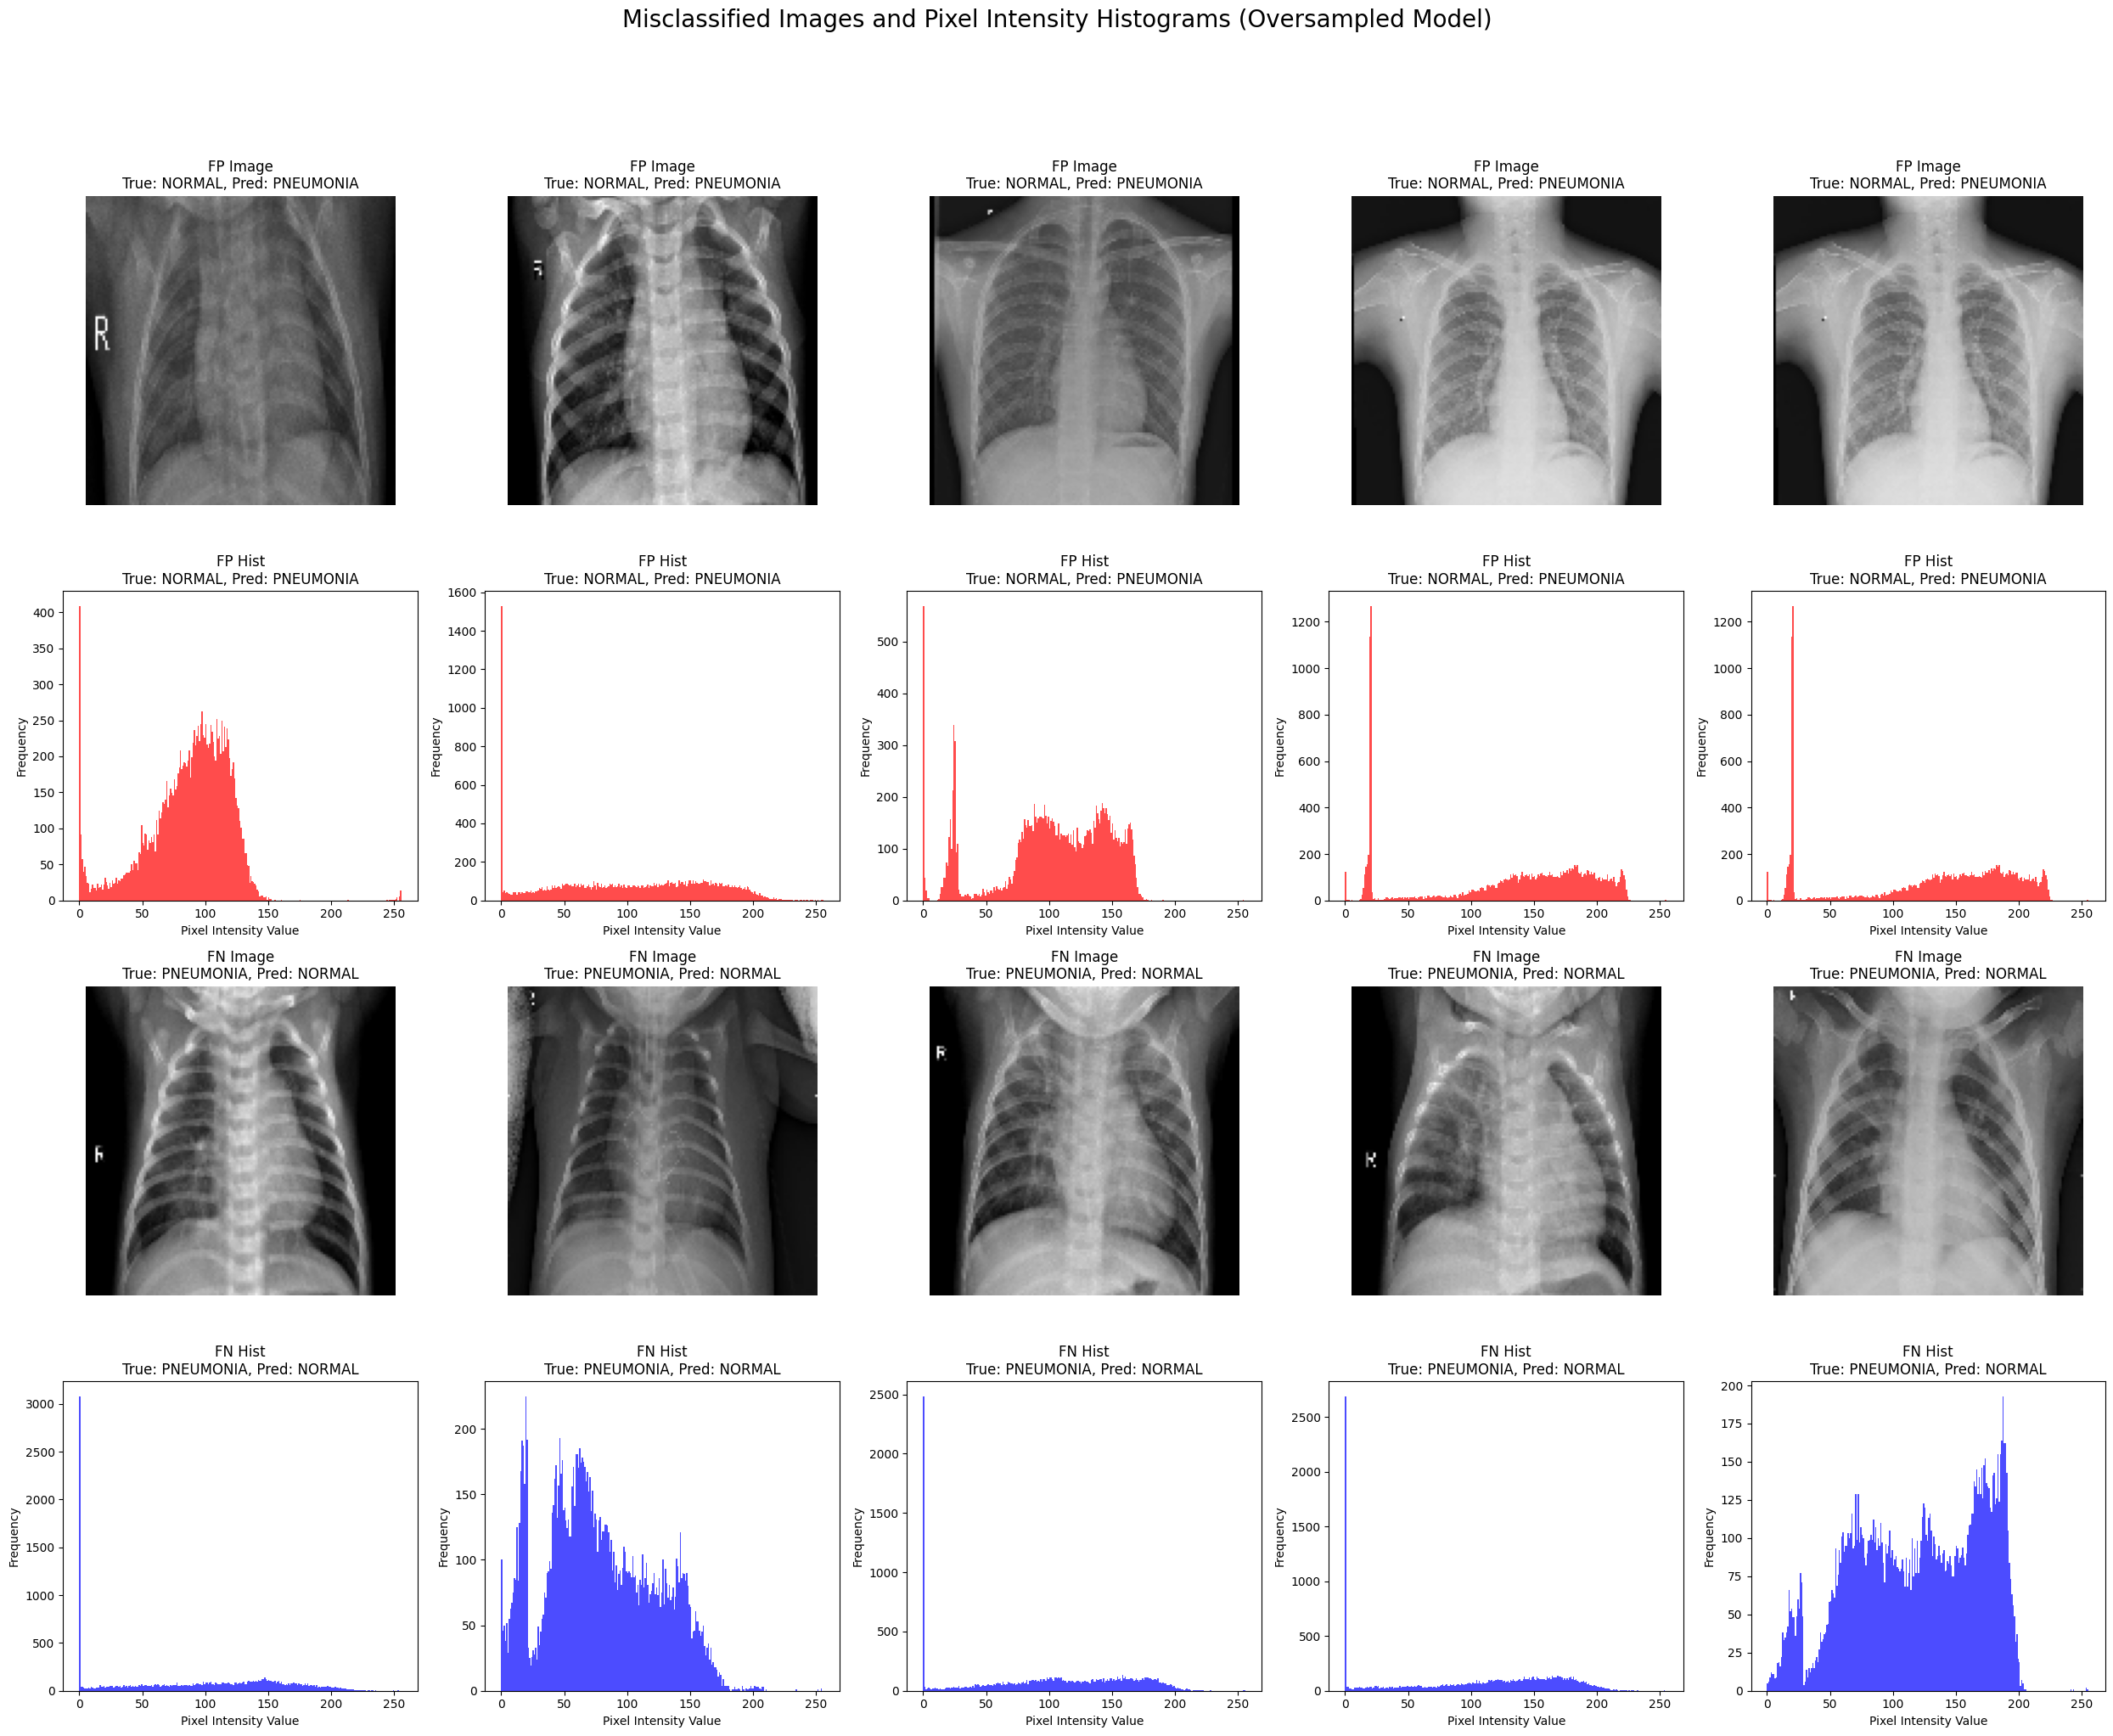

In [ ]:
y_true_np = np.array(y_true)
y_pred_oversampled = y_pred_balanced # Using predictions from the oversampled model

misclassified_indices_oversampled = np.where(y_true_np != y_pred_oversampled)[0]

misclassified_filenames_oversampled = test_df.iloc[misclassified_indices_oversampled]['filename'].values
misclassified_true_labels_numeric_oversampled = y_true_np[misclassified_indices_oversampled]
misclassified_predicted_labels_numeric_oversampled = y_pred_oversampled[misclassified_indices_oversampled]

# Create a mapping from numeric label to class name
label_map = {v: k for k, v in test_generator.class_indices.items()}

misclassified_true_labels_str_oversampled = [label_map[label] for label in misclassified_true_labels_numeric_oversampled]
misclassified_predicted_labels_str_oversampled = [label_map[label] for label in misclassified_predicted_labels_numeric_oversampled]

misclassified_df_oversampled = pd.DataFrame({
    'filename': misclassified_filenames_oversampled,
    'true_label': misclassified_true_labels_str_oversampled,
    'predicted_label': misclassified_predicted_labels_str_oversampled
})

print("Number of misclassified images (Oversampled Model):", len(misclassified_df_oversampled))
print("First 5 misclassified images (Oversampled Model):")
print(misclassified_df_oversampled.head())

false_positives_df_oversampled = misclassified_df_oversampled[
    (misclassified_df_oversampled['true_label'] == 'NORMAL') &
    (misclassified_df_oversampled['predicted_label'] == 'PNEUMONIA')
]

false_negatives_df_oversampled = misclassified_df_oversampled[
    (misclassified_df_oversampled['true_label'] == 'PNEUMONIA') &
    (misclassified_df_oversampled['predicted_label'] == 'NORMAL')
]

print(f"\nNumber of False Positives (Normal predicted as Pneumonia) (Oversampled Model): {len(false_positives_df_oversampled)}")
print(f"Number of False Negatives (Pneumonia predicted as Normal) (Oversampled Model): {len(false_negatives_df_oversampled)}")

num_samples_to_plot = 5
fp_samples_oversampled = false_positives_df_oversampled.head(num_samples_to_plot)
fn_samples_oversampled = false_negatives_df_oversampled.head(num_samples_to_plot)

fig, axes = plt.subplots(4, 5, figsize=(25, 20))
fig.suptitle('Misclassified Images and Pixel Intensity Histograms (Oversampled Model)', fontsize=20, y=1.02)

# Row 1: False Positive Images (Normal -> Pneumonia)
for i, (idx, row) in enumerate(fp_samples_oversampled.iterrows()):
    img = cv2.imread(row['filename'])
    if img is not None:
        img = cv2.resize(img, (128, 128)) # Resize image to 128x128
        axes[0, i].imshow(img, cmap='gray')
        axes[0, i].set_title(f"FP Image\nTrue: {row['true_label']}, Pred: {row['predicted_label']}")
    else:
        axes[0, i].set_title(f"FP Image\nCould not load {os.path.basename(row['filename'])}")
    axes[0, i].axis('off')

# Row 2: False Positive Histograms
for i, (idx, row) in enumerate(fp_samples_oversampled.iterrows()):
    img_gray = cv2.imread(row['filename'], cv2.IMREAD_GRAYSCALE)
    if img_gray is not None:
        img_gray = cv2.resize(img_gray, (128, 128)) # Resize for histogram as well for consistency
        axes[1, i].hist(img_gray.ravel(), bins=256, range=(0, 256), color='red', alpha=0.7)
        axes[1, i].set_title(f"FP Hist\nTrue: {row['true_label']}, Pred: {row['predicted_label']}")
        axes[1, i].set_xlabel('Pixel Intensity Value')
        axes[1, i].set_ylabel('Frequency')
    else:
        axes[1, i].set_title(f"FP Hist\nCould not load {os.path.basename(row['filename'])}")

# Row 3: False Negative Images (Pneumonia -> Normal)
for i, (idx, row) in enumerate(fn_samples_oversampled.iterrows()):
    img = cv2.imread(row['filename'])
    if img is not None:
        img = cv2.resize(img, (128, 128)) # Resize image to 128x128
        axes[2, i].imshow(img, cmap='gray')
        axes[2, i].set_title(f"FN Image\nTrue: {row['true_label']}, Pred: {row['predicted_label']}")
    else:
        axes[2, i].set_title(f"FN Image\nCould not load {os.path.basename(row['filename'])}")
    axes[2, i].axis('off')

# Row 4: False Negative Histograms
for i, (idx, row) in enumerate(fn_samples_oversampled.iterrows()):
    img_gray = cv2.imread(row['filename'], cv2.IMREAD_GRAYSCALE)
    if img_gray is not None:
        img_gray = cv2.resize(img_gray, (128, 128)) # Resize for histogram as well for consistency
        axes[3, i].hist(img_gray.ravel(), bins=256, range=(0, 256), color='blue', alpha=0.7)
        axes[3, i].set_title(f"FN Hist\nTrue: {row['true_label']}, Pred: {row['predicted_label']}")
        axes[3, i].set_xlabel('Pixel Intensity Value')
        axes[3, i].set_ylabel('Frequency')
    else:
        axes[3, i].set_title(f"FN Hist\nCould not load {os.path.basename(row['filename'])}")

plt.tight_layout(rect=[0, 0, 1, 0.96]) # Adjust rect to prevent title overlap
plt.show()

# UNDERSAMPLING
- separate the `train_df` into two dataframes: one for the 'NORMAL' class (minority) and one for the 'PNEUMONIA' class (majority)
- apply undersampling


In [ ]:
normal_df = train_df[train_df['class_name'] == 'NORMAL']
pneumonia_df = train_df[train_df['class_name'] == 'PNEUMONIA']

print(f"normal_df shape: {normal_df.shape}")
print(f"pneumonia_df shape: {pneumonia_df.shape}")

normal_df shape: (1341, 2)
pneumonia_df shape: (3875, 2)


In [ ]:
num_normal = len(normal_df)
undersampled_pneumonia_df = pneumonia_df.sample(n=num_normal, replace=False, random_state=42)

print(f"normal_df shape: {normal_df.shape}")
print(f"undersampled_pneumonia_df shape: {undersampled_pneumonia_df.shape}")

normal_df shape: (1341, 2)
undersampled_pneumonia_df shape: (1341, 2)


In [ ]:
balanced_train_df_undersampled = pd.concat([normal_df, undersampled_pneumonia_df], axis=0)
balanced_train_df_undersampled = balanced_train_df_undersampled.sample(frac=1, random_state=42).reset_index(drop=True)

print(f"Shape of the new balanced (undersampled) training dataframe: {balanced_train_df_undersampled.shape}")
print(f"Value counts of classes in balanced_train_df_undersampled:\n{balanced_train_df_undersampled['class_name'].value_counts()}")

Shape of the new balanced (undersampled) training dataframe: (2682, 2)
Value counts of classes in balanced_train_df_undersampled:
class_name
NORMAL       1341
PNEUMONIA    1341
Name: count, dtype: int64


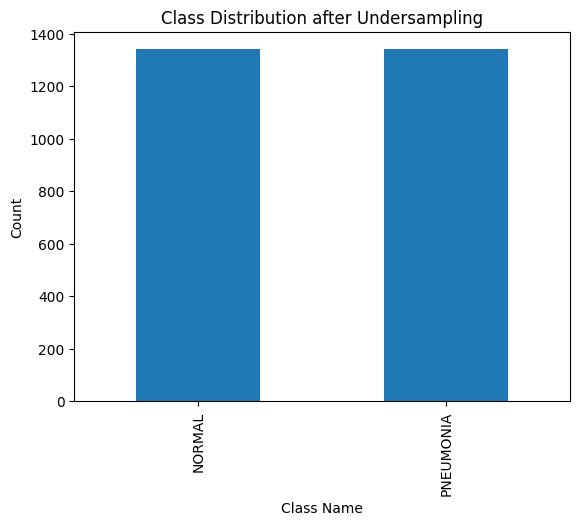

In [ ]:
balanced_train_df_undersampled['class_name'].value_counts().plot(kind='bar', title='Class Distribution after Undersampling')
plt.xlabel('Class Name')
plt.ylabel('Count')
plt.show()

In [ ]:
train_generator = train_datagen.flow_from_dataframe(
    balanced_train_df_undersampled,
    x_col='filename',
    y_col='class_name',
    target_size=(128, 128),
    color_mode='grayscale',
    class_mode='categorical',
    batch_size=32,
    shuffle=True
)

Found 2682 validated image filenames belonging to 2 classes.
Recreated train_generator with balanced_train_df_undersampled.


In [ ]:
history_balanced_undersampled = model.fit(
    train_generator,
    epochs=20,
    validation_data=val_generator,
    callbacks=callbacks
)

Retraining model with balanced (undersampled) training data...
Epoch 1/20
84/84 ━━━━━━━━━━━━━━━━━━━━ 309s 4s/step - accuracy: 0.9131 - loss: 0.2923 - val_accuracy: 0.7500 - val_loss: 0.5503
Epoch 2/20
84/84 ━━━━━━━━━━━━━━━━━━━━ 281s 3s/step - accuracy: 0.8997 - loss: 0.3065 - val_accuracy: 0.8750 - val_loss: 0.2791
Epoch 3/20
84/84 ━━━━━━━━━━━━━━━━━━━━ 248s 3s/step - accuracy: 0.9083 - loss: 0.2832 - val_accuracy: 0.8750 - val_loss: 0.3267
Model retraining complete.


In [ ]:
y_prob_undersampled = model.predict(test_generator)
y_pred_undersampled = np.argmax(y_prob_undersampled, axis=1)

precision_undersampled = precision_score(y_true, y_pred_undersampled, pos_label=1)
recall_undersampled = recall_score(y_true, y_pred_undersampled, pos_label=1)
f1_undersampled = f1_score(y_true, y_pred_undersampled, pos_label=1)
cm_undersampled = confusion_matrix(y_true, y_pred_undersampled)

print(f"Precision (Undersampled): {precision_undersampled:.4f}")
print(f"Recall (Undersampled): {recall_undersampled:.4f}")
print(f"F1-score (Undersampled): {f1_undersampled:.4f}")
print(f"Confusion Matrix (Undersampled):\n{cm_undersampled}")

20/20 ━━━━━━━━━━━━━━━━━━━━ 24s 1s/step
Precision (Undersampled): 0.8272
Recall (Undersampled): 0.9821
F1-score (Undersampled): 0.8980
Confusion Matrix (Undersampled):
[[154  80]
 [  7 383]]


Number of misclassified images (Undersampled Model): 87
First 5 misclassified images (Undersampled Model):
                                            filename true_label  \
0  C:\Users\katev\.cache\kagglehub\datasets\pault...     NORMAL   
1  C:\Users\katev\.cache\kagglehub\datasets\pault...     NORMAL   
2  C:\Users\katev\.cache\kagglehub\datasets\pault...     NORMAL   
3  C:\Users\katev\.cache\kagglehub\datasets\pault...     NORMAL   
4  C:\Users\katev\.cache\kagglehub\datasets\pault...     NORMAL   

  predicted_label  
0       PNEUMONIA  
1       PNEUMONIA  
2       PNEUMONIA  
3       PNEUMONIA  
4       PNEUMONIA  

Number of False Positives (Normal predicted as Pneumonia) (Undersampled Model): 80
Number of False Negatives (Pneumonia predicted as Normal) (Undersampled Model): 7


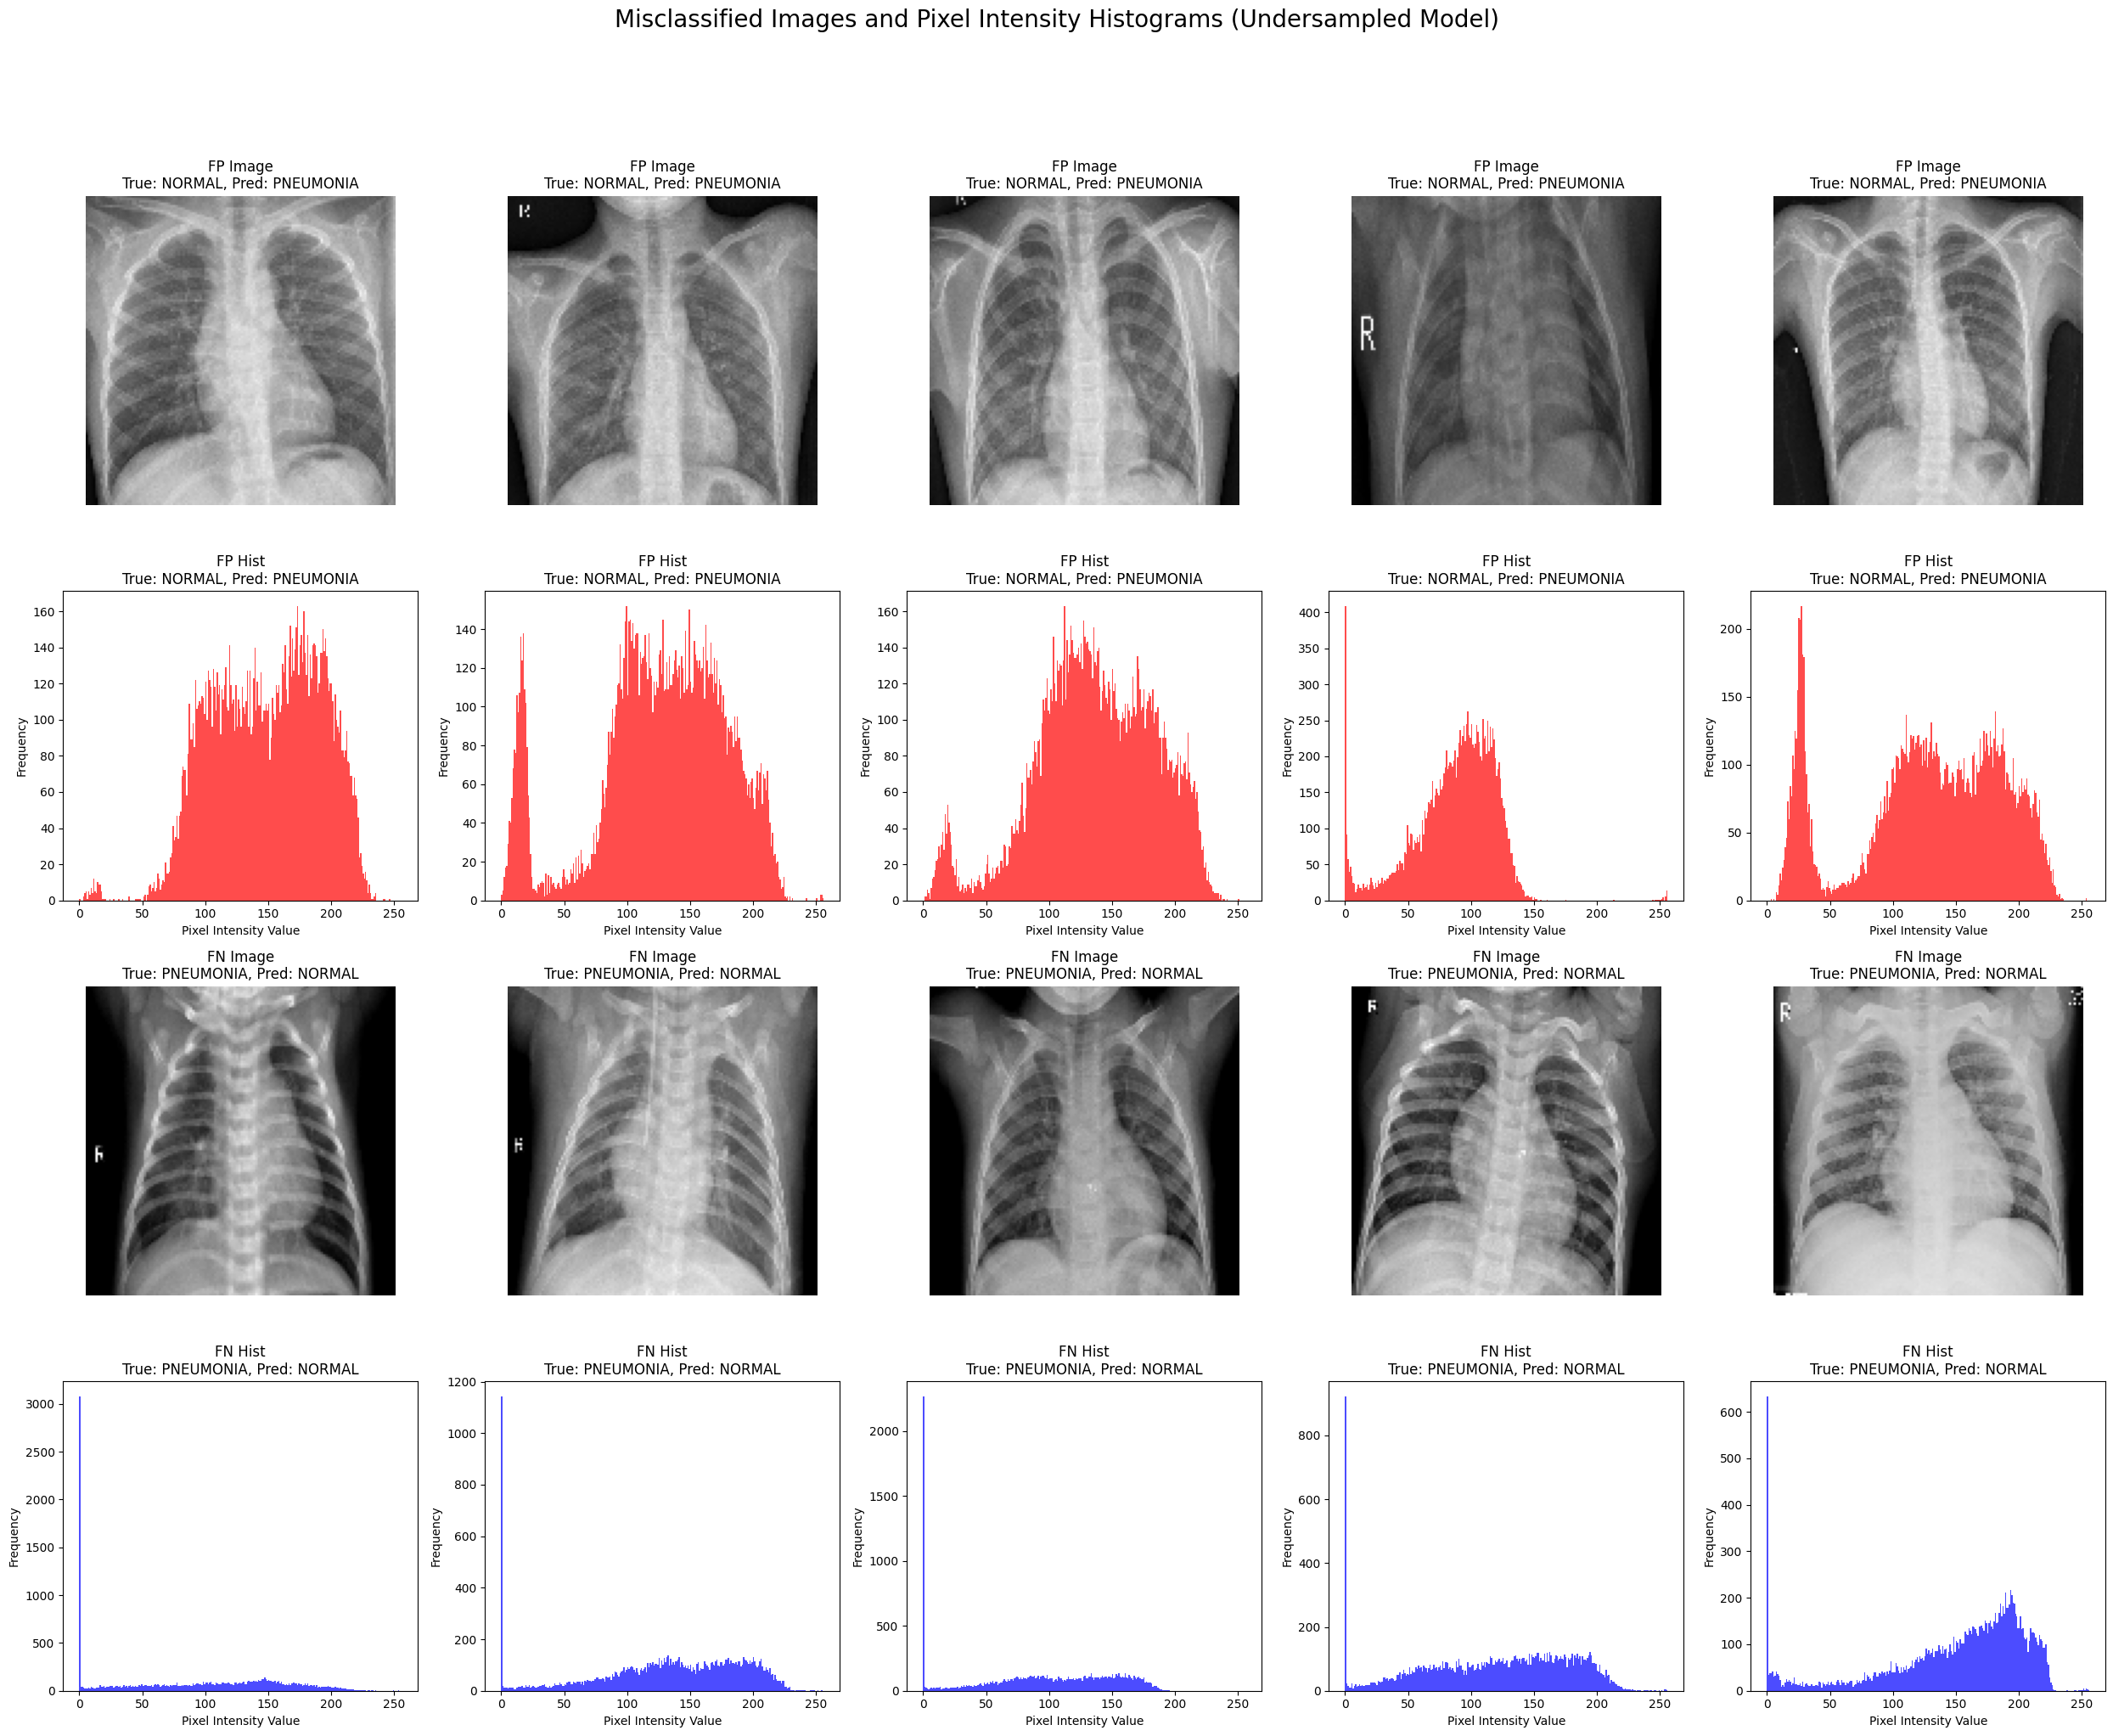

In [ ]:
y_true_np = np.array(y_true)
y_pred_undersampled_model = y_pred_undersampled # Using predictions from the undersampled model

misclassified_indices_undersampled = np.where(y_true_np != y_pred_undersampled_model)[0]

misclassified_filenames_undersampled = test_df.iloc[misclassified_indices_undersampled]['filename'].values
misclassified_true_labels_numeric_undersampled = y_true_np[misclassified_indices_undersampled]
misclassified_predicted_labels_numeric_undersampled = y_pred_undersampled_model[misclassified_indices_undersampled]

# Create a mapping from numeric label to class name
label_map = {v: k for k, v in test_generator.class_indices.items()}

misclassified_true_labels_str_undersampled = [label_map[label] for label in misclassified_true_labels_numeric_undersampled]
misclassified_predicted_labels_str_undersampled = [label_map[label] for label in misclassified_predicted_labels_numeric_undersampled]

misclassified_df_undersampled = pd.DataFrame({
    'filename': misclassified_filenames_undersampled,
    'true_label': misclassified_true_labels_str_undersampled,
    'predicted_label': misclassified_predicted_labels_str_undersampled
})

print("Number of misclassified images (Undersampled Model):", len(misclassified_df_undersampled))
print("First 5 misclassified images (Undersampled Model):")
print(misclassified_df_undersampled.head())

false_positives_df_undersampled = misclassified_df_undersampled[
    (misclassified_df_undersampled['true_label'] == 'NORMAL') &
    (misclassified_df_undersampled['predicted_label'] == 'PNEUMONIA')
]

false_negatives_df_undersampled = misclassified_df_undersampled[
    (misclassified_df_undersampled['true_label'] == 'PNEUMONIA') &
    (misclassified_df_undersampled['predicted_label'] == 'NORMAL')
]

print(f"\nNumber of False Positives (Normal predicted as Pneumonia) (Undersampled Model): {len(false_positives_df_undersampled)}")
print(f"Number of False Negatives (Pneumonia predicted as Normal) (Undersampled Model): {len(false_negatives_df_undersampled)}")

num_samples_to_plot = 5
fp_samples_undersampled = false_positives_df_undersampled.head(num_samples_to_plot)
fn_samples_undersampled = false_negatives_df_undersampled.head(num_samples_to_plot)

fig, axes = plt.subplots(4, 5, figsize=(25, 20))
fig.suptitle('Misclassified Images and Pixel Intensity Histograms (Undersampled Model)', fontsize=20, y=1.02)

# Row 1: False Positive Images (Normal -> Pneumonia)
for i, (idx, row) in enumerate(fp_samples_undersampled.iterrows()):
    img = cv2.imread(row['filename'])
    if img is not None:
        img = cv2.resize(img, (128, 128)) # Resize image to 128x128
        axes[0, i].imshow(img, cmap='gray')
        axes[0, i].set_title(f"FP Image\nTrue: {row['true_label']}, Pred: {row['predicted_label']}")
    else:
        axes[0, i].set_title(f"FP Image\nCould not load {os.path.basename(row['filename'])}")
    axes[0, i].axis('off')

# Row 2: False Positive Histograms
for i, (idx, row) in enumerate(fp_samples_undersampled.iterrows()):
    img_gray = cv2.imread(row['filename'], cv2.IMREAD_GRAYSCALE)
    if img_gray is not None:
        img_gray = cv2.resize(img_gray, (128, 128)) # Resize for histogram as well for consistency
        axes[1, i].hist(img_gray.ravel(), bins=256, range=(0, 256), color='red', alpha=0.7)
        axes[1, i].set_title(f"FP Hist\nTrue: {row['true_label']}, Pred: {row['predicted_label']}")
        axes[1, i].set_xlabel('Pixel Intensity Value')
        axes[1, i].set_ylabel('Frequency')
    else:
        axes[1, i].set_title(f"FP Hist\nCould not load {os.path.basename(row['filename'])}")

# Row 3: False Negative Images (Pneumonia -> Normal)
for i, (idx, row) in enumerate(fn_samples_undersampled.iterrows()):
    img = cv2.imread(row['filename'])
    if img is not None:
        img = cv2.resize(img, (128, 128)) # Resize image to 128x128
        axes[2, i].imshow(img, cmap='gray')
        axes[2, i].set_title(f"FN Image\nTrue: {row['true_label']}, Pred: {row['predicted_label']}")
    else:
        axes[2, i].set_title(f"FN Image\nCould not load {os.path.basename(row['filename'])}")
    axes[2, i].axis('off')

# Row 4: False Negative Histograms
for i, (idx, row) in enumerate(fn_samples_undersampled.iterrows()):
    img_gray = cv2.imread(row['filename'], cv2.IMREAD_GRAYSCALE)
    if img_gray is not None:
        img_gray = cv2.resize(img_gray, (128, 128)) # Resize for histogram as well for consistency
        axes[3, i].hist(img_gray.ravel(), bins=256, range=(0, 256), color='blue', alpha=0.7)
        axes[3, i].set_title(f"FN Hist\nTrue: {row['true_label']}, Pred: {row['predicted_label']}")
        axes[3, i].set_xlabel('Pixel Intensity Value')
        axes[3, i].set_ylabel('Frequency')
    else:
        axes[3, i].set_title(f"FN Hist\nCould not load {os.path.basename(row['filename'])}")

plt.tight_layout(rect=[0, 0, 1, 0.96]) # Adjust rect to prevent title overlap
plt.show()

# CM HEATMAP - over under

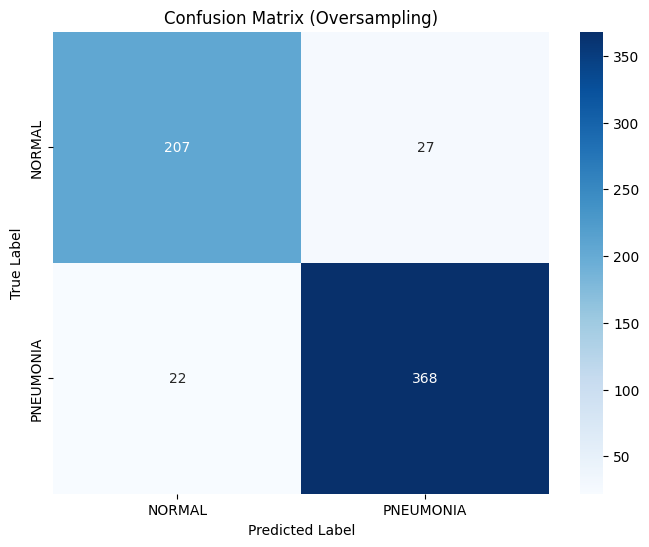

In [ ]:
class_names = ['NORMAL', 'PNEUMONIA']

plt.figure(figsize=(8, 6))
sns.heatmap(cm_balanced, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix (Oversampling)')
plt.show()

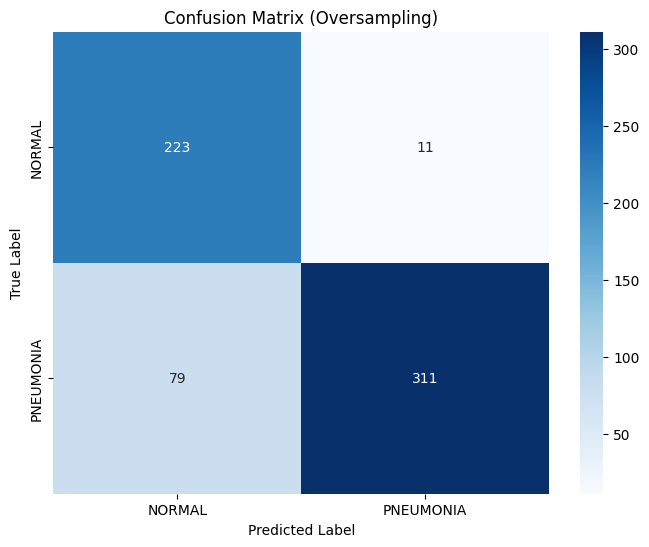

In [ ]:
class_names = ['NORMAL', 'PNEUMONIA']

plt.figure(figsize=(8, 6))
sns.heatmap(cm_undersampled, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix (Undersampling)')
plt.show()

# PLOT DATA FOR REPORT

In [ ]:
import pandas as pd

data = {
    'Model': ['Model 1', 'Model 2', 'Model 3', 'Model 4'],
    'Scenario': ['Baseline', 'Oversampling', 'Undersampling', 'Class Weighting'],
    'Accuracy': [0.7965, 0.9215, 0.8558, 0.8734],
    'Precision': [0.7563, 0.9316, 0.9658, 0.9331],
    'Recall': [0.9949, 0.9436, 0.7974, 0.8590],
    'F1-score': [0.8594, 0.9376, 0.8736, 0.8945],
    'Time Taken (s)': [1, 1.54, 0.29, 1.77]
}

df_metrics = pd.DataFrame(data)

print(df_metrics)

     Model         Scenario  Accuracy  Precision  Recall  F1-score  \
0  Model 1         Baseline    0.7965     0.7563  0.9949    0.8594   
1  Model 2     Oversampling    0.9215     0.9316  0.9436    0.9376   
2  Model 3    Undersampling    0.8558     0.9658  0.7974    0.8736   
3  Model 4  Class Weighting    0.8734     0.9331  0.8590    0.8945   

   Time Taken (s)  
0            1.00  
1            1.54  
2            0.29  
3            1.77  


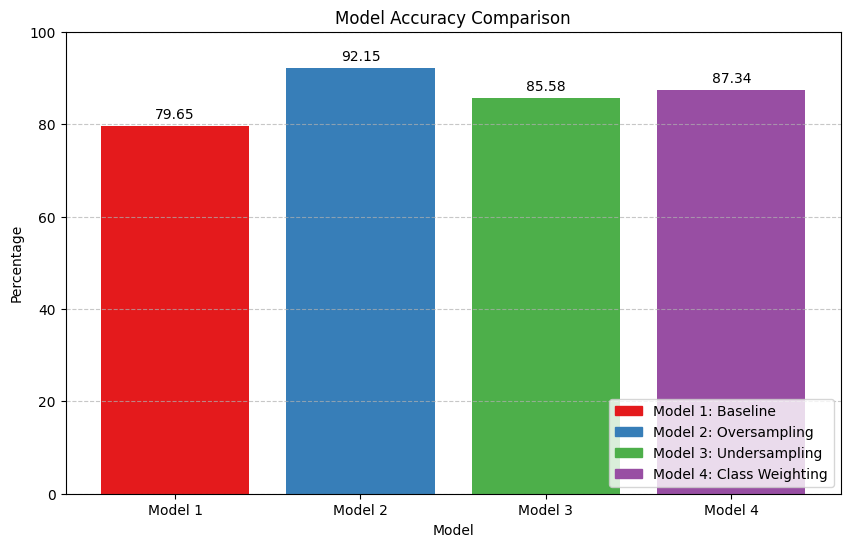

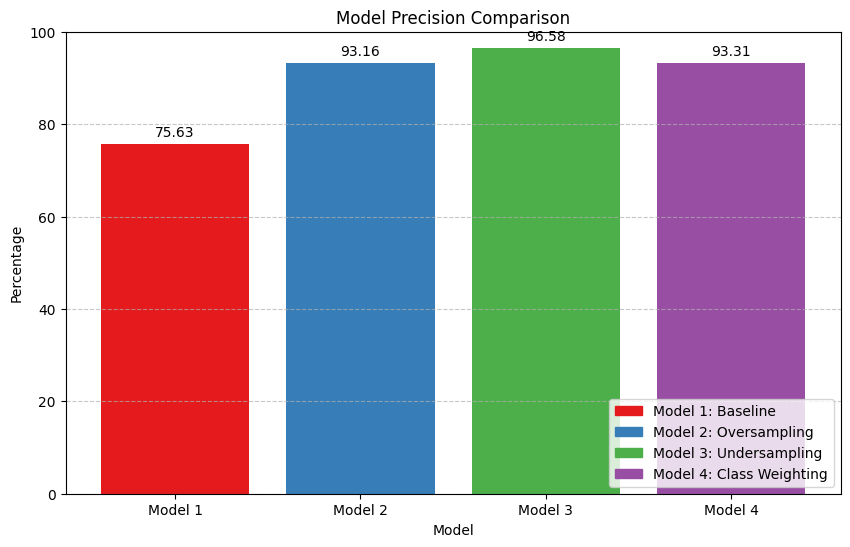

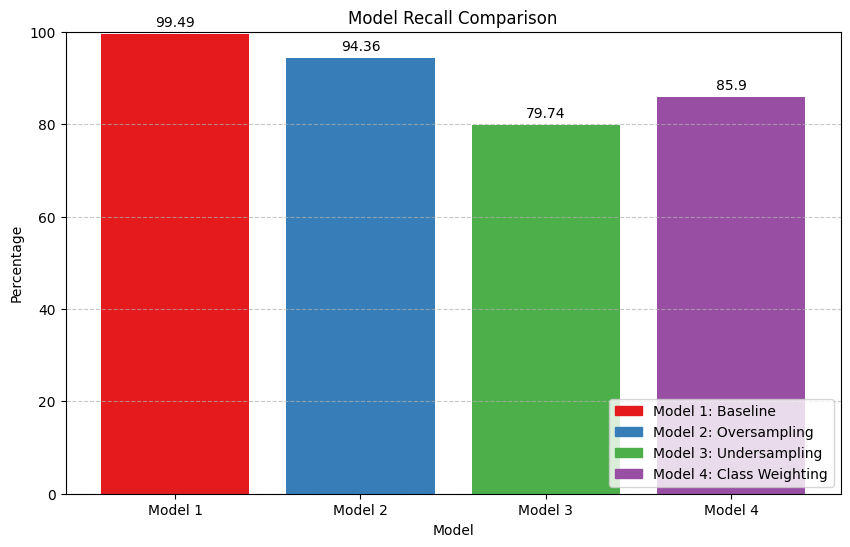

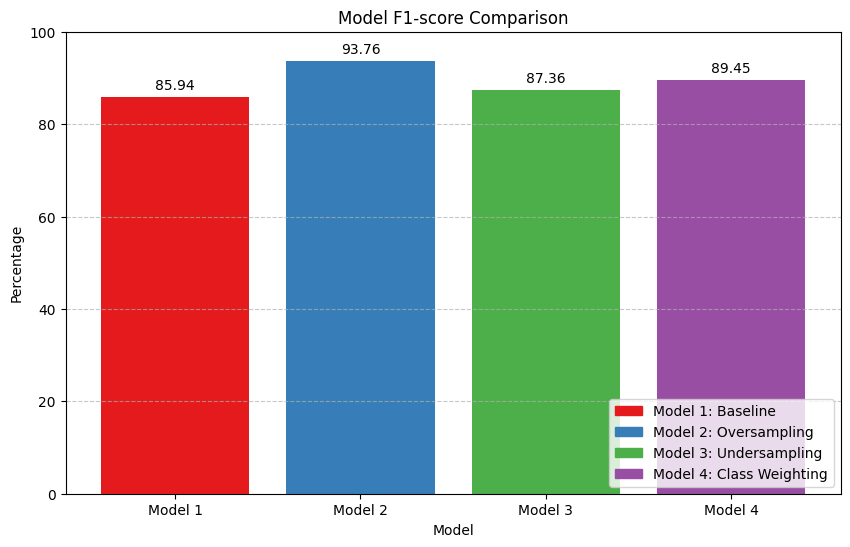

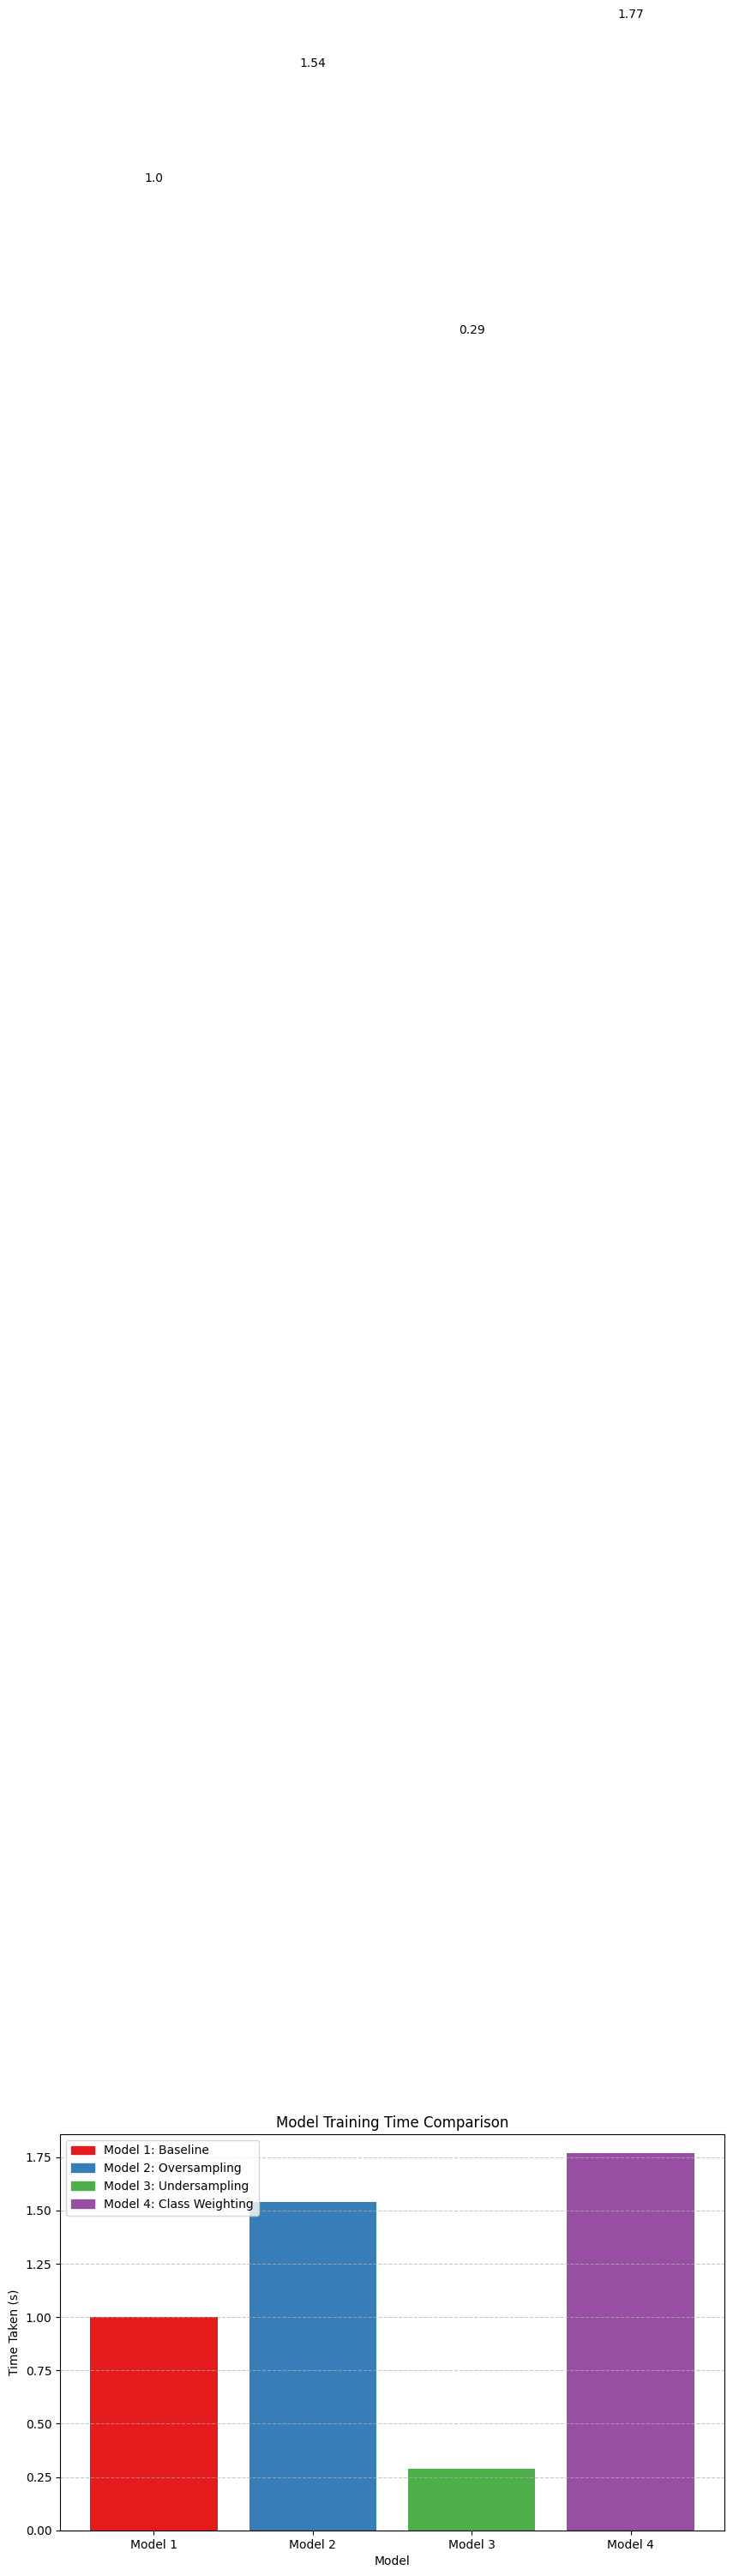

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.cm as cm

tab10_cmap = plt.colormaps.get_cmap('Set1')
colors = [tab10_cmap(i) for i in range(4)]

legend_handles = [plt.Rectangle((0,0),1,1, color=colors[i], label=f'{df_metrics["Model"][i]}: {df_metrics["Scenario"][i]}') for i in range(len(df_metrics))]

# Plot for Accuracy
plt.figure(figsize=(10, 6))
bars_accuracy = plt.bar(df_metrics['Model'], df_metrics['Accuracy'] * 100, color=colors)
plt.xlabel('Model')
plt.ylabel('Percentage')
plt.title('Model Accuracy Comparison')
plt.ylim(0, 100)
for bar in bars_accuracy:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 1, round(yval, 2), ha='center', va='bottom')
plt.legend(handles=legend_handles, loc='lower right')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

# Plot for Precision
plt.figure(figsize=(10, 6))
bars_precision = plt.bar(df_metrics['Model'], df_metrics['Precision'] * 100, color=colors)
plt.xlabel('Model')
plt.ylabel('Percentage')
plt.title('Model Precision Comparison')
plt.ylim(0, 100)
for bar in bars_precision:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 1, round(yval, 2), ha='center', va='bottom')
plt.legend(handles=legend_handles, loc='lower right')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

# Plot for Recall
plt.figure(figsize=(10, 6))
bars_recall = plt.bar(df_metrics['Model'], df_metrics['Recall'] * 100, color=colors)
plt.xlabel('Model')
plt.ylabel('Percentage')
plt.title('Model Recall Comparison')
plt.ylim(0, 100)
for bar in bars_recall:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 1, round(yval, 2), ha='center', va='bottom')
plt.legend(handles=legend_handles, loc='lower right')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

# Plot for F1-score
plt.figure(figsize=(10, 6))
bars_f1 = plt.bar(df_metrics['Model'], df_metrics['F1-score'] * 100, color=colors)
plt.xlabel('Model')
plt.ylabel('Percentage')
plt.title('Model F1-score Comparison')
plt.ylim(0, 100)
for bar in bars_f1:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 1, round(yval, 2), ha='center', va='bottom')
plt.legend(handles=legend_handles, loc='lower right')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

# Plot for 'Time Taken (s)'
plt.figure(figsize=(10, 6))
bars_time = plt.bar(df_metrics['Model'], df_metrics['Time Taken (s)'], color=colors)
plt.xlabel('Model')
plt.ylabel('Time Taken (s)')
plt.title('Model Training Time Comparison')
for bar in bars_time:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 10, round(yval, 2), ha='center', va='bottom')
plt.legend(handles=legend_handles, loc='upper left')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

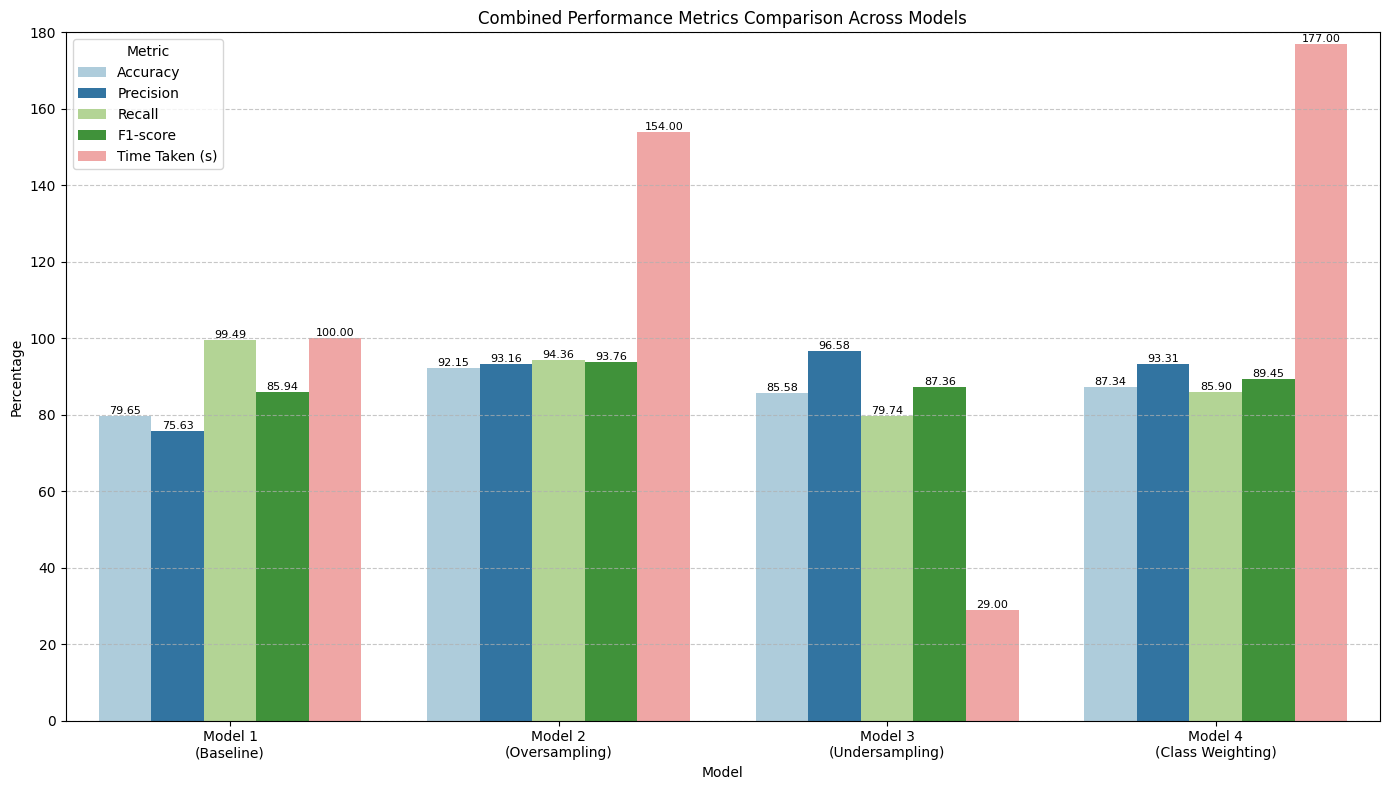

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import matplotlib.patches as mpatches

# Prepare data for combined plot: melt the DataFrame to long format
# Exclude 'Time Taken (s)' and 'Scenario' as they are not part of this plot
metrics_to_melt = ['Accuracy', 'Precision', 'Recall', 'F1-score', 'Time Taken (s)']
df_combined = df_metrics.melt(id_vars=['Model', 'Scenario'], value_vars=metrics_to_melt, var_name='Metric', value_name='Value')

# Convert values to percentage
df_combined['Value'] = df_combined['Value'] * 100

plt.figure(figsize=(14, 8))
sns.barplot(x='Model', y='Value', hue='Metric', data=df_combined, palette='Paired')

plt.xlabel('Model')
plt.ylabel('Percentage')
plt.title('Combined Performance Metrics Comparison Across Models')
plt.ylim(0, 180)

# Create custom legend handles to include Scenario names with Metric colors
# We will let seaborn create the default metric legend and augment it if needed.

# Let's adjust x-tick labels to include scenario for better context
model_labels = [f'{row.Model}\n({row.Scenario})' for index, row in df_metrics.iterrows()]
plt.xticks(ticks=range(len(df_metrics)), labels=model_labels)

# Adjust legend location to be inside the plot at the upper left corner
plt.legend(title='Metric', loc='upper left')

# Display values on top of bars
for container in plt.gca().containers:
    for bar in container:
        height = bar.get_height()
        if pd.notna(height): # Check for NaN values
            plt.text(bar.get_x() + bar.get_width() / 2, height, f'{height:.2f}', ha='center', va='bottom', fontsize=8)

plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()